<a href="https://colab.research.google.com/github/daniellcosmo/CBM_Naval_Propulsion_Plant/blob/main/CBM_Naval_Propulsion_Plant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema

Datase: http://archive.ics.uci.edu/ml/datasets/condition+based+maintenance+of+naval+propulsion+plants


y1 [GT Compressor decay state coefficient] <br>
y2 [GT Turbine decay state coefficient]


#Importação dos Dados

In [1]:
%pip install optuna #optuna-3.1.0-py3-none-any.whl
%pip install bayesian-optimization #bayesian-optimization-1.4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd #1.3.5
import numpy as np #1.22.4

import seaborn as sns #0.11.2
import matplotlib.pyplot as plt #3.5.3

from sklearn.preprocessing import MinMaxScaler #1.2.1
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor #1.7.4
import scipy.stats as stats #1.10.1

import plotly.express as px #5.5.0
import plotly.graph_objects as go

import optuna #3.1.0
from optuna.samplers import TPESampler

import time
from copy import deepcopy
import pickle

In [4]:
path = 'https://raw.githubusercontent.com/daniellcosmo/CBM_Naval_Propulsion_Plant/main/dataset/'
df = pd.read_csv(path + 'data.txt', sep="   ", header=None, engine='python')

Features = [
 'lever_position',
 'ship_speed',
 'GT_shaft_torque',
 'GT_rpm',
 'GG_rpm',
 'S_prplr_torque',
 'P_prplr_torque',
 'HP_T_exit_temp',
 'GT_C_airIn_temp',
 'GT_C_airOut_temp',
 'HP_T_exit_pressure',
 'GT_C_airIn_pressure',
 'GT_C_airOut_pressure',
 'GT_exhGas_pressure',
 'T_inj_control',
 'fuel_flow',
 'GT_C_decay_coef',
 'GT_T_decay_coef']
df.columns = Features
df.head()

lever_position  ship_speed  GT_shaft_torque    GT_rpm    GG_rpm  \
0           1.138         3.0          289.964  1349.489  6677.380   
1           2.088         6.0         6960.180  1376.166  6828.469   
2           3.144         9.0         8379.229  1386.757  7111.811   
3           4.161        12.0        14724.395  1547.465  7792.630   
4           5.140        15.0        21636.432  1924.313  8494.777   

   S_prplr_torque  P_prplr_torque  HP_T_exit_temp  GT_C_airIn_temp  \
0           7.584           7.584         464.006            288.0   
1          28.204          28.204         635.401            288.0   
2          60.358          60.358         606.002            288.0   
3         113.774         113.774         661.471            288.0   
4         175.306         175.306         731.494            288.0   

   GT_C_airOut_temp  HP_T_exit_pressure  GT_C_airIn_pressure  \
0           550.563               1.096                0.998   
1           581.658               1.331                0.998   
2           587.587               1.389                0.998   
3           613.851               1.658                0.998   
4           645.642               2.078                0.998   

   GT_C_airOut_pressure  GT_exhGas_pressure  T_inj_control  fuel_flow  \
0                 5.947               1.019          7.137      0.082   
1                 7.282               1.019         10.655      0.287   
2                 7.574               1.020         13.086      0.259   
3                 9.007               1.022         18.109      0.358   
4                11.197               1.026         26.373      0.522   

   GT_C_decay_coef  GT_T_decay_coef  
0             0.95            0.975  
1             0.95            0.975  
2             0.95            0.975  
3             0.95            0.975  
4             0.95            0.975

In [5]:
FeaturesNames = pd.read_csv(path + "Features.txt", sep="   ", header=None, engine='python')
FeaturesNames.values.tolist()

[['1 - Lever position (lp) [ ]'],
 ['2 - Ship speed (v) [knots]'],
 ['3 - Gas Turbine shaft torque (GTT) [kN m]'],
 ['4 - Gas Turbine rate of revolutions (GTn) [rpm]'],
 ['5 - Gas Generator rate of revolutions (GGn) [rpm]'],
 ['6 - Starboard Propeller Torque (Ts) [kN]'],
 ['7 - Port Propeller Torque (Tp) [kN]'],
 ['8 - HP Turbine exit temperature (T48) [C]'],
 ['9 - GT Compressor inlet air temperature (T1) [C]'],
 ['10 - GT Compressor outlet air temperature (T2) [C]'],
 ['11 - HP Turbine exit pressure (P48) [bar]'],
 ['12 - GT Compressor inlet air pressure (P1) [bar]'],
 ['13 - GT Compressor outlet air pressure (P2) [bar]'],
 ['14 - Gas Turbine exhaust gas pressure (Pexh) [bar]'],
 ['15 - Turbine Injecton Control (TIC) [%]'],
 ['16 - Fuel flow (mf) [kg/s]'],
 ['17 - GT Compressor decay state coefficient.'],
 ['18 - GT Turbine decay state coefficient.']]

#2. Análise dos Dados

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lever_position        11934 non-null  float64
 1   ship_speed            11934 non-null  float64
 2   GT_shaft_torque       11934 non-null  float64
 3   GT_rpm                11934 non-null  float64
 4   GG_rpm                11934 non-null  float64
 5   S_prplr_torque        11934 non-null  float64
 6   P_prplr_torque        11934 non-null  float64
 7   HP_T_exit_temp        11934 non-null  float64
 8   GT_C_airIn_temp       11934 non-null  float64
 9   GT_C_airOut_temp      11934 non-null  float64
 10  HP_T_exit_pressure    11934 non-null  float64
 11  GT_C_airIn_pressure   11934 non-null  float64
 12  GT_C_airOut_pressure  11934 non-null  float64
 13  GT_exhGas_pressure    11934 non-null  float64
 14  T_inj_control         11934 non-null  float64
 15  fuel_flow          

In [7]:
df.describe()

lever_position    ship_speed  GT_shaft_torque        GT_rpm  \
count    11934.000000  11934.000000     11934.000000  11934.000000   
mean         5.166667     15.000000     27247.498685   2136.289256   
std          2.626388      7.746291     22148.613155    774.083881   
min          1.138000      3.000000       253.547000   1307.675000   
25%          3.144000      9.000000      8375.883750   1386.758000   
50%          5.140000     15.000000     21630.659000   1924.326000   
75%          7.148000     21.000000     39001.426750   2678.079000   
max          9.300000     27.000000     72784.872000   3560.741000   

             GG_rpm  S_prplr_torque  P_prplr_torque  HP_T_exit_temp  \
count  11934.000000    11934.000000    11934.000000    11934.000000   
mean    8200.947312      227.335768      227.335768      735.495446   
std     1091.315507      200.495889      200.495889      173.680552   
min     6589.002000        5.304000        5.304000      442.364000   
25%     7058.324000       60.317000       60.317000      589.872750   
50%     8482.081500      175.268000      175.268000      706.038000   
75%     9132.606000      332.364750      332.364750      834.066250   
max     9797.103000      645.249000      645.249000     1115.797000   

       GT_C_airIn_temp  GT_C_airOut_temp  HP_T_exit_pressure  \
count          11934.0      11934.000000        11934.000000   
mean             288.0        646.215331            2.352963   
std                0.0         72.675882            1.084770   
min              288.0        540.442000            1.093000   
25%              288.0        578.092250            1.389000   
50%              288.0        637.141500            2.083000   
75%              288.0        693.924500            2.981000   
max              288.0        789.094000            4.560000   

       GT_C_airIn_pressure  GT_C_airOut_pressure  GT_exhGas_pressure  \
count         1.193400e+04          11934.000000        11934.000000   
mean          9.980000e-01             12.297123            1.029474   
std           2.220539e-16              5.337448            0.010390   
min           9.980000e-01              5.828000            1.019000   
25%           9.980000e-01              7.447250            1.020000   
50%           9.980000e-01             11.092000            1.026000   
75%           9.980000e-01             15.658000            1.036000   
max           9.980000e-01             23.140000            1.052000   

       T_inj_control     fuel_flow  GT_C_decay_coef  GT_T_decay_coef  
count   11934.000000  11934.000000      11934.00000       11934.0000  
mean       33.641261      0.662440          0.97500           0.9875  
std        25.841363      0.507132          0.01472           0.0075  
min         0.000000      0.068000          0.95000           0.9750  
25%        13.677500      0.246000          0.96200           0.9810  
50%        25.276500      0.496000          0.97500           0.9875  
75%        44.552500      0.882000          0.98800           0.9940  
max        92.556000      1.832000          1.00000           1.0000

##BoxPlot Normalizado

In [8]:
x = df.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_df = pd.DataFrame(x_scaled)
normalized_df.columns = Features

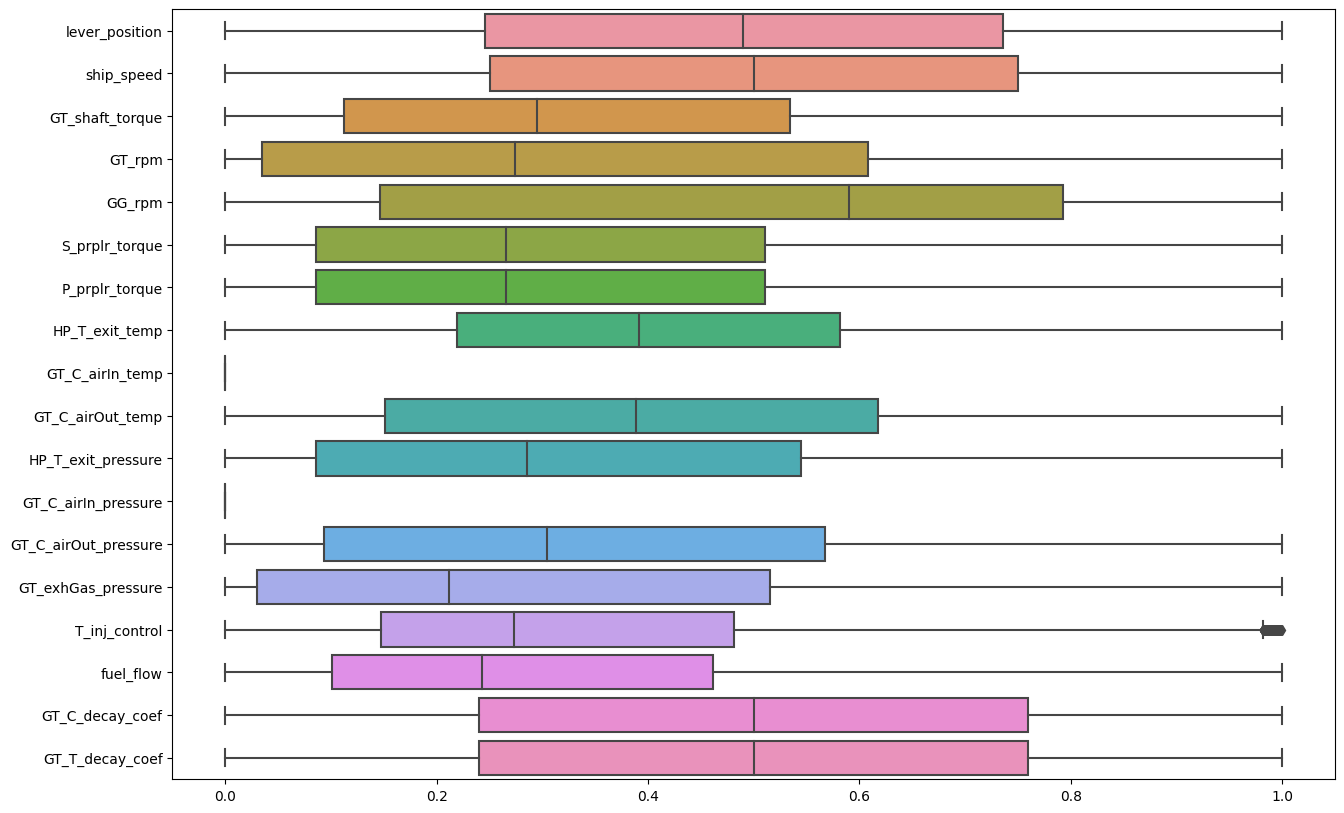

In [9]:
fig, ax = plt.subplots(figsize=(15,10))
_= sns.boxplot(data=normalized_df, dodge=False, orient="h")

Como é possível visualizar, as features: 
*   GT_C__airIn_pressure; e
*   GT_C__airIn_temp

possuem std igual a zero, comportando-se como constante sem fazer um impacto no resultado final.
<br>
Dado isso, podemos removê-las do modelo.

In [10]:
try:
  f1 = 'GT_C_airIn_temp'
  f2 = 'GT_C_airIn_pressure'
  df=df.drop(f1, axis=1)
  print('Removida feature ', f1)
  df=df.drop(f2, axis=1)
  print('Removida feature ', f2)
except Exception:
  print('Feature(s) já não se encontram no DataFrame')
  pass

Removida feature  GT_C_airIn_temp
Removida feature  GT_C_airIn_pressure


##Gráfico dos n primeiros valores das variáveis

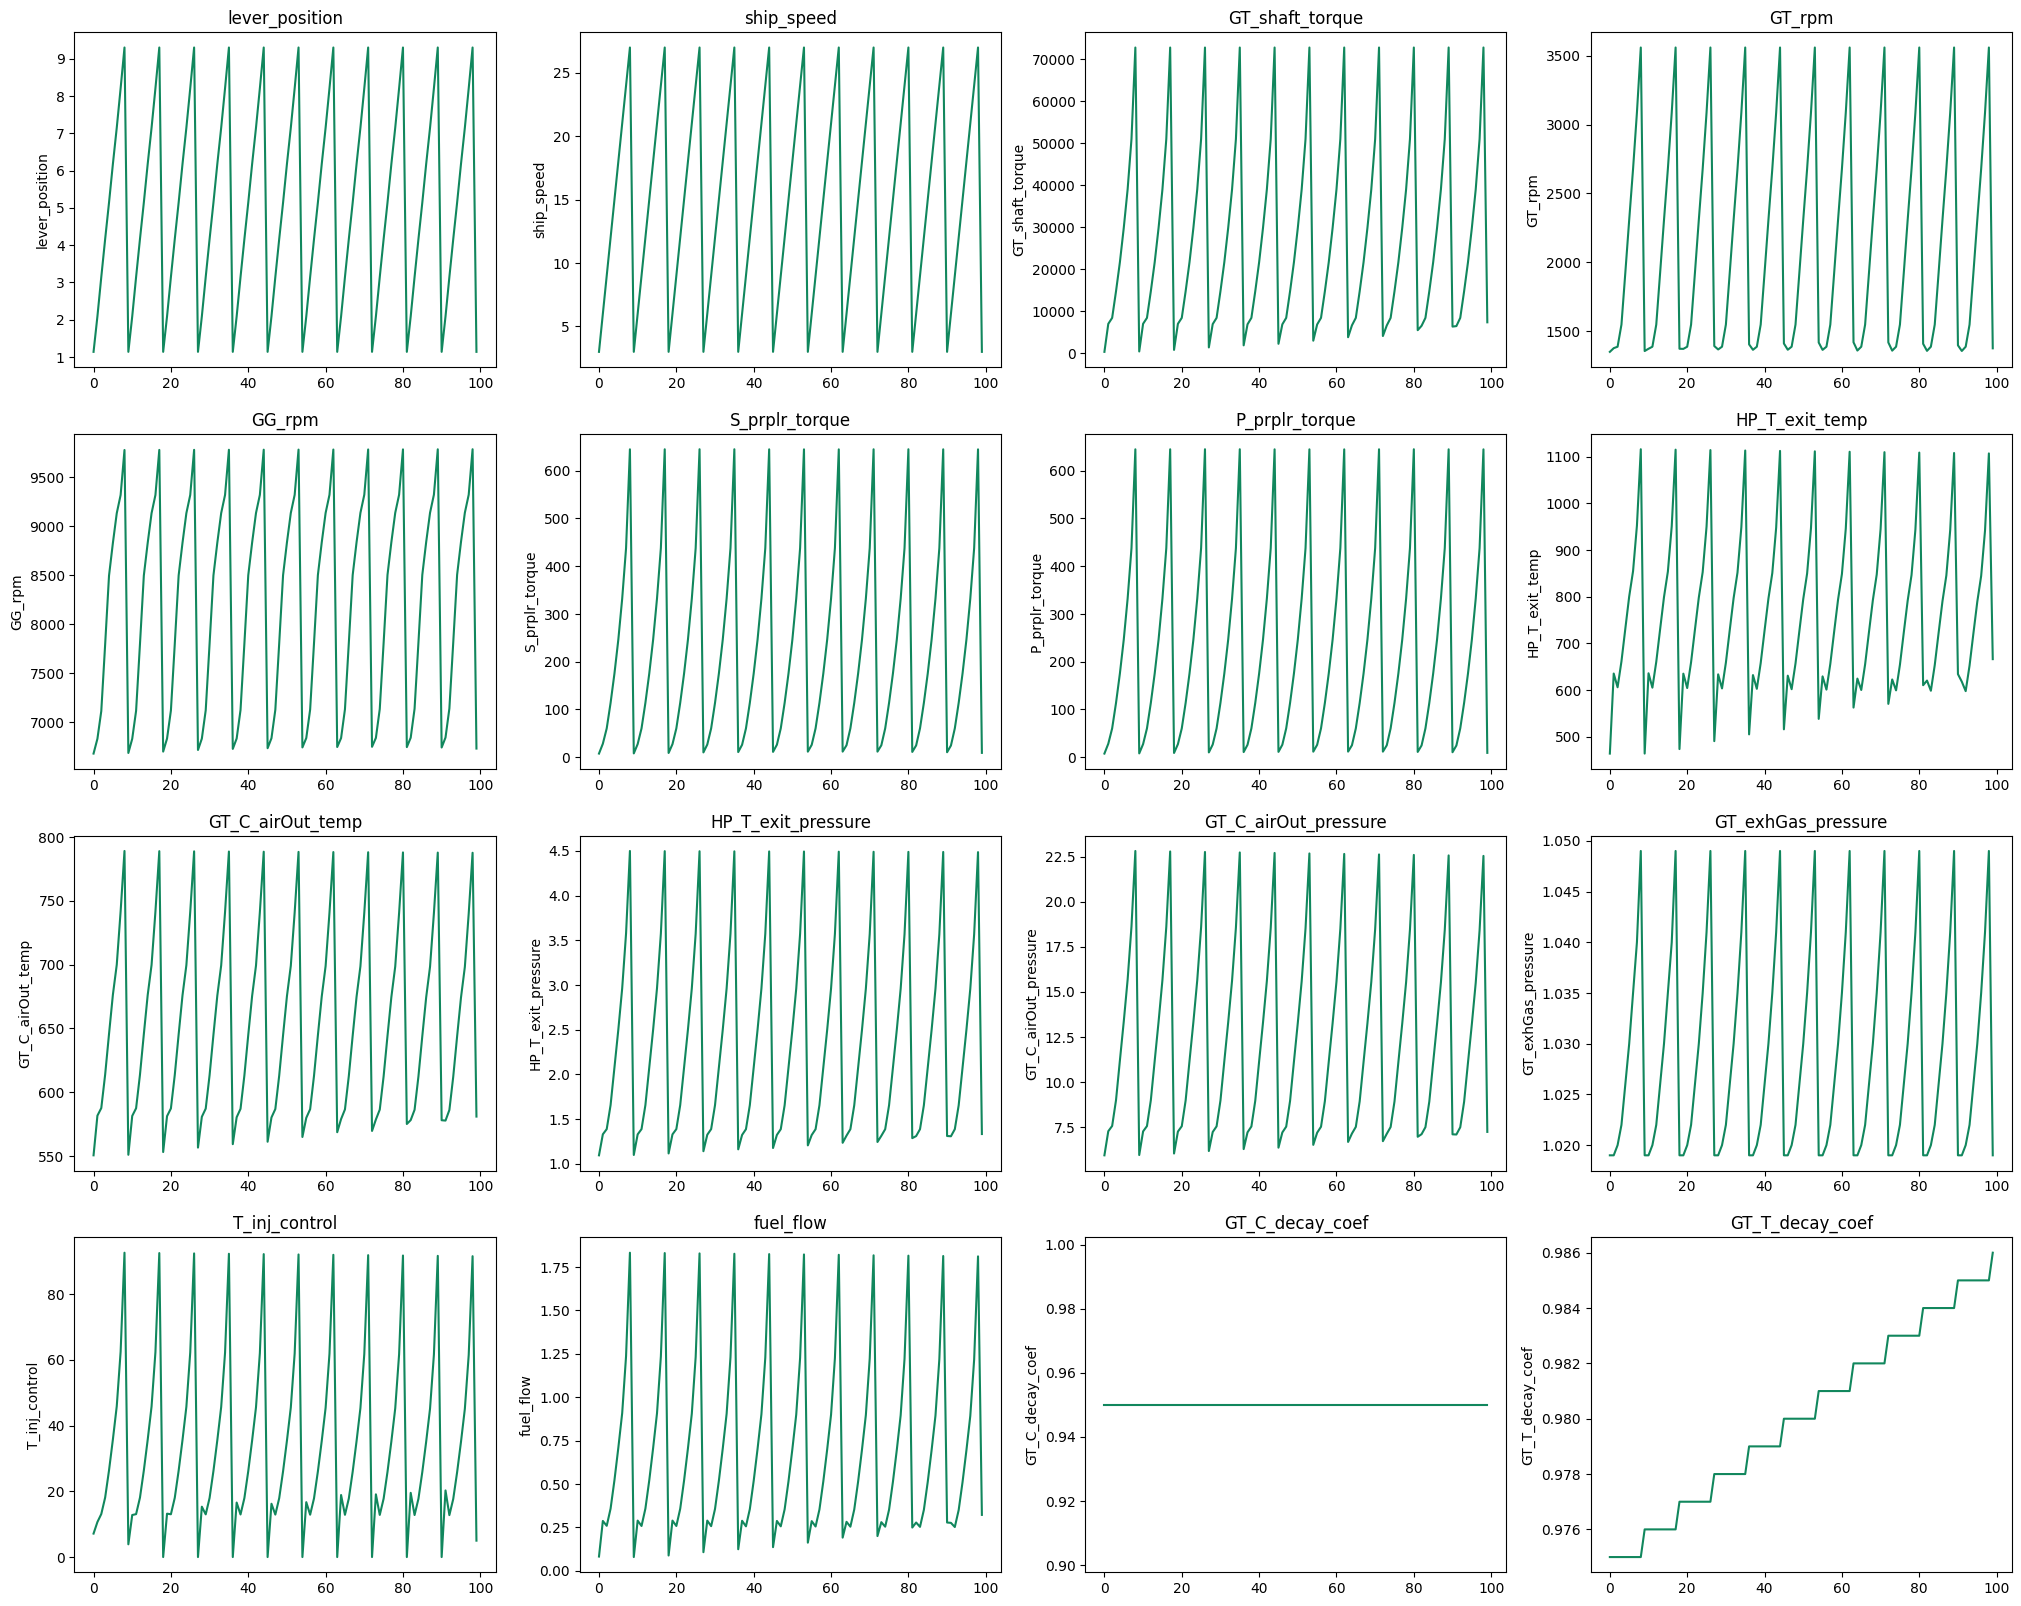

In [11]:
n = 100

fig, axes = plt.subplots(nrows = 4, ncols = 4)    # axes is 2d array (4x4)
axes = axes.flatten()         # Convert axes to 1d array of length nrows x rcols
fig.set_size_inches(25, 20)

for ax, col in zip(axes, df.columns):
  sns.lineplot(x = [*range(n)], y = df[col][:n], ax = ax, color=sns.xkcd_rgb['dark sea green']).set(xlabel=None)
  ax.set_title(col)

##Histograma de Frequências e Distribuição Normal

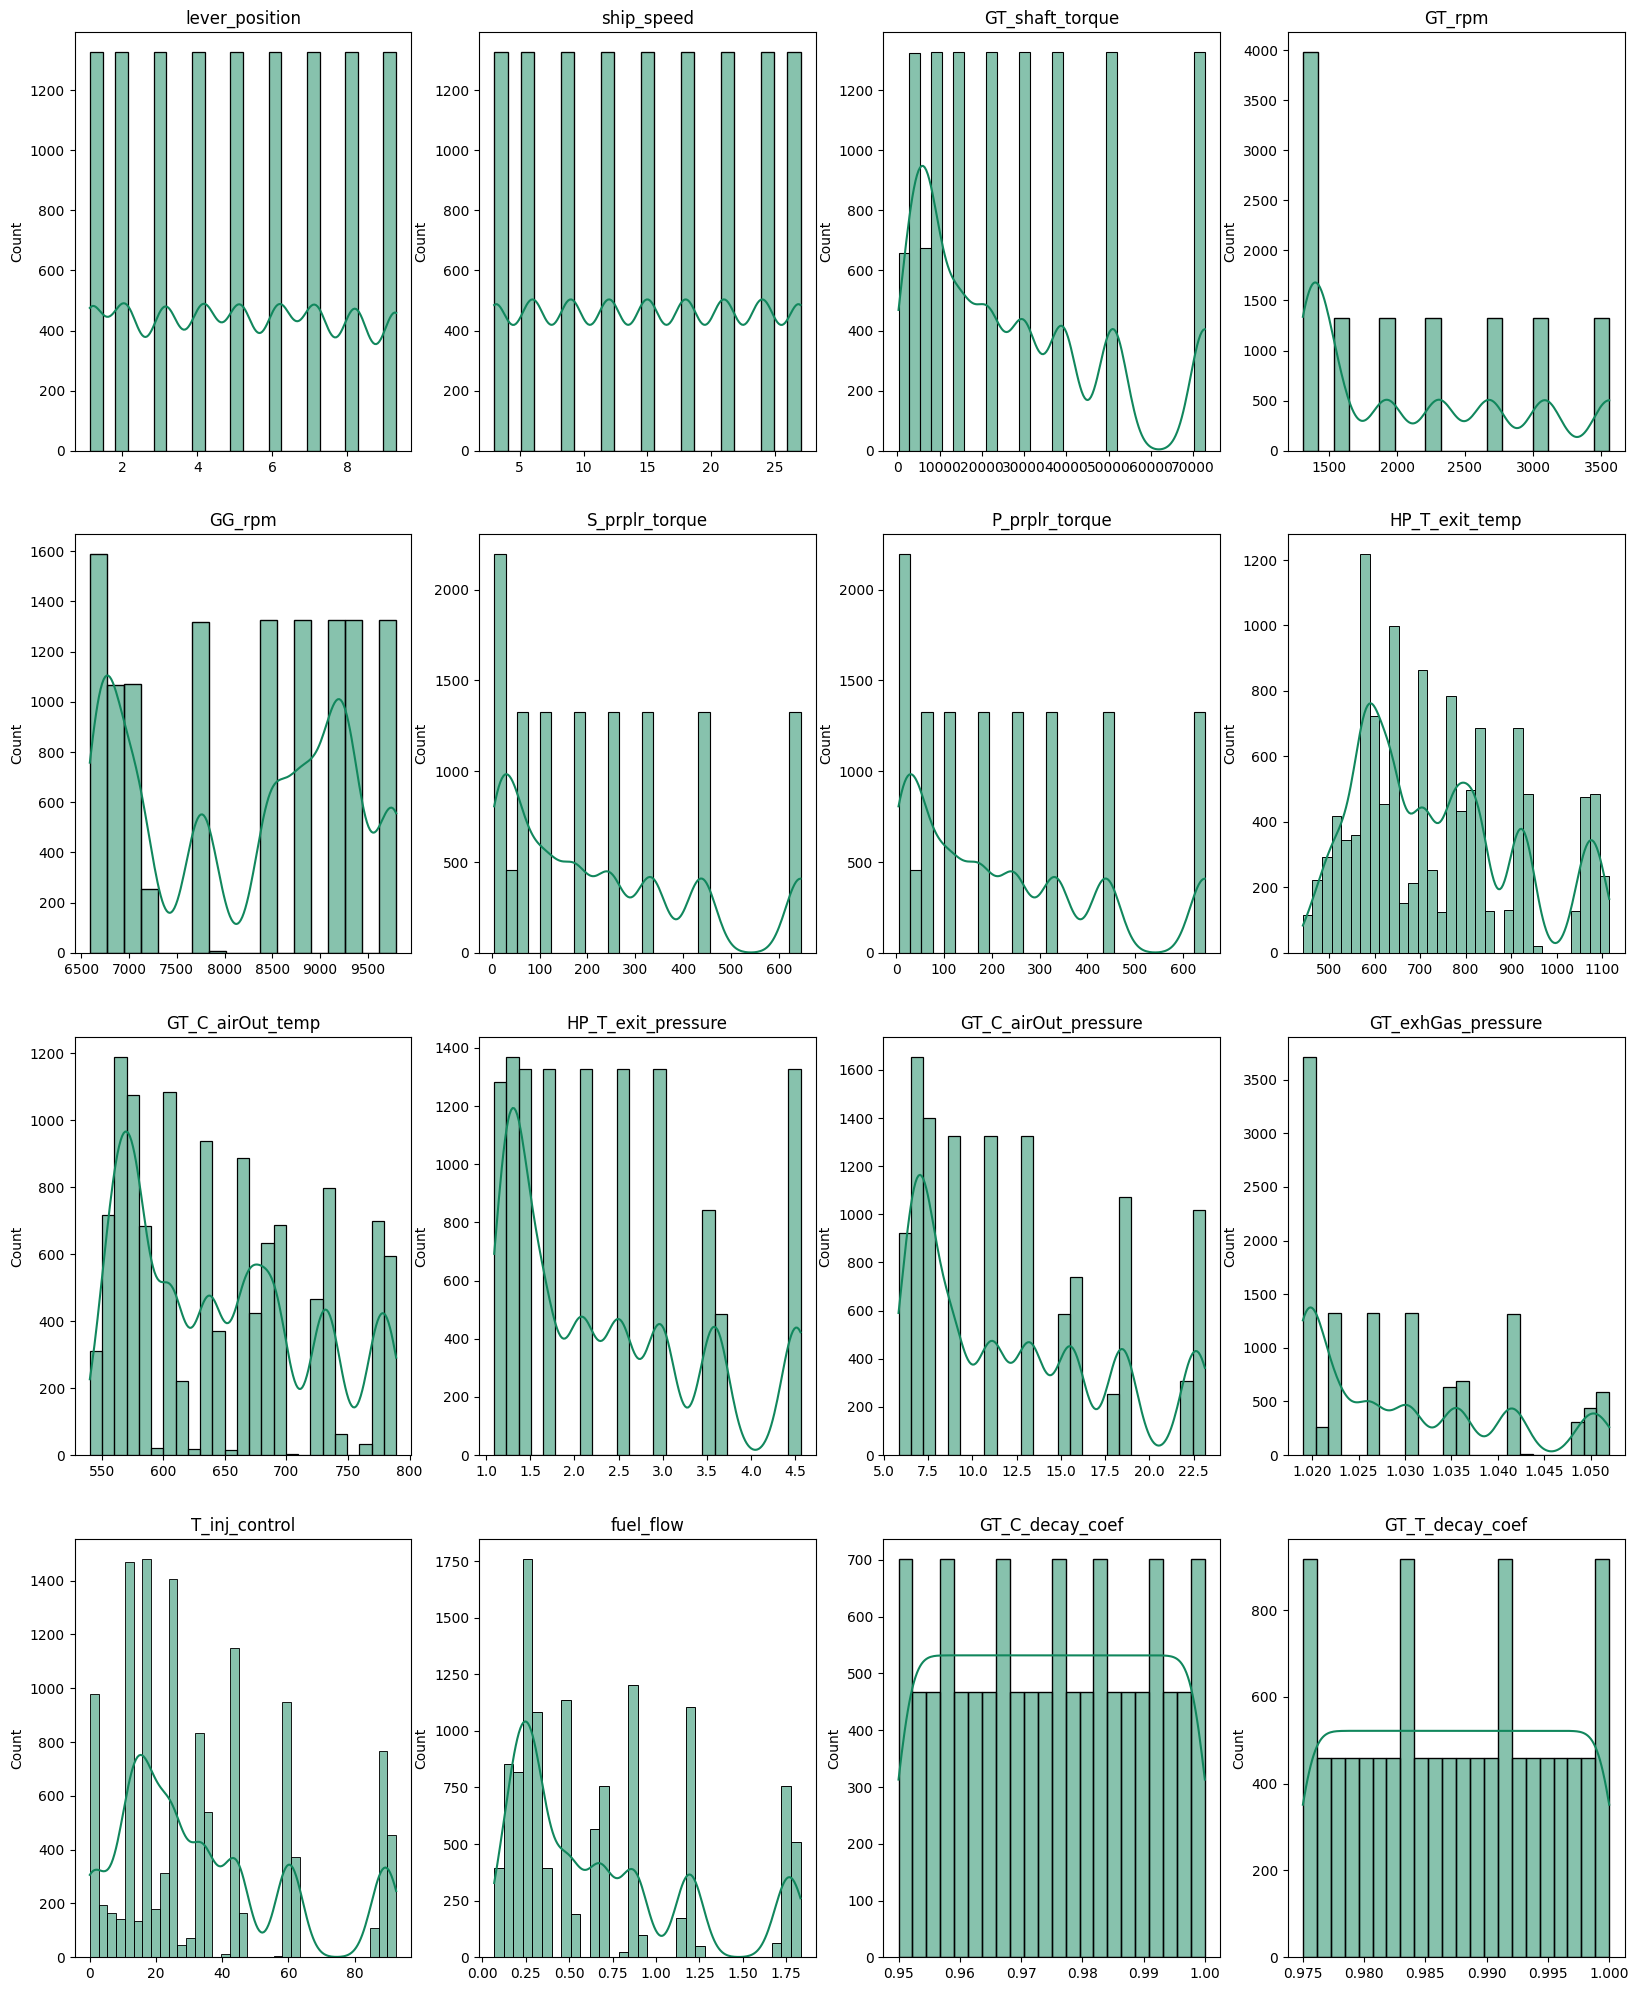

In [12]:
# sns.displot(df['lever_position'], kde=True)
# https://www.biomooc.com/color/seabornColors.html

fig, axes = plt.subplots(nrows = 4, ncols = 4)    # axes is 2d array (4x4)
axes = axes.flatten()         # Convert axes to 1d array of length nrows x rcols
fig.set_size_inches(20, 25)

for ax, col in zip(axes, df.columns):
  sns.histplot(df[col], ax = ax, kde=True, color=sns.xkcd_rgb['dark sea green']).set(xlabel=None) # , label="Compact"
  ax.set_title(col)



##Teste de Normalidade de Kolmogorov-Smirnov



In [13]:
testeNormal = pd.DataFrame(index=[ "Segue Distribuição Normal?"])

for col in df.columns:
    stat,p= stats.normaltest(df[col])
    if p<=0.05:
        testeNormal[col] = 'Não'
    else:
        testeNormal[col] = 'Sim'

testeNormal = testeNormal.T
testeNormal

Segue Distribuição Normal?
lever_position                              Não
ship_speed                                  Não
GT_shaft_torque                             Não
GT_rpm                                      Não
GG_rpm                                      Não
S_prplr_torque                              Não
P_prplr_torque                              Não
HP_T_exit_temp                              Não
GT_C_airOut_temp                            Não
HP_T_exit_pressure                          Não
GT_C_airOut_pressure                        Não
GT_exhGas_pressure                          Não
T_inj_control                               Não
fuel_flow                                   Não
GT_C_decay_coef                             Não
GT_T_decay_coef                             Não

Ou seja, o valor-p foi menor do que nosso nível de significância, logo, a probabilidade de obtermos dados como estes é muito pequena. Assim, podemos concluir que os valores não seguem distribuição normal.

## Heatmap

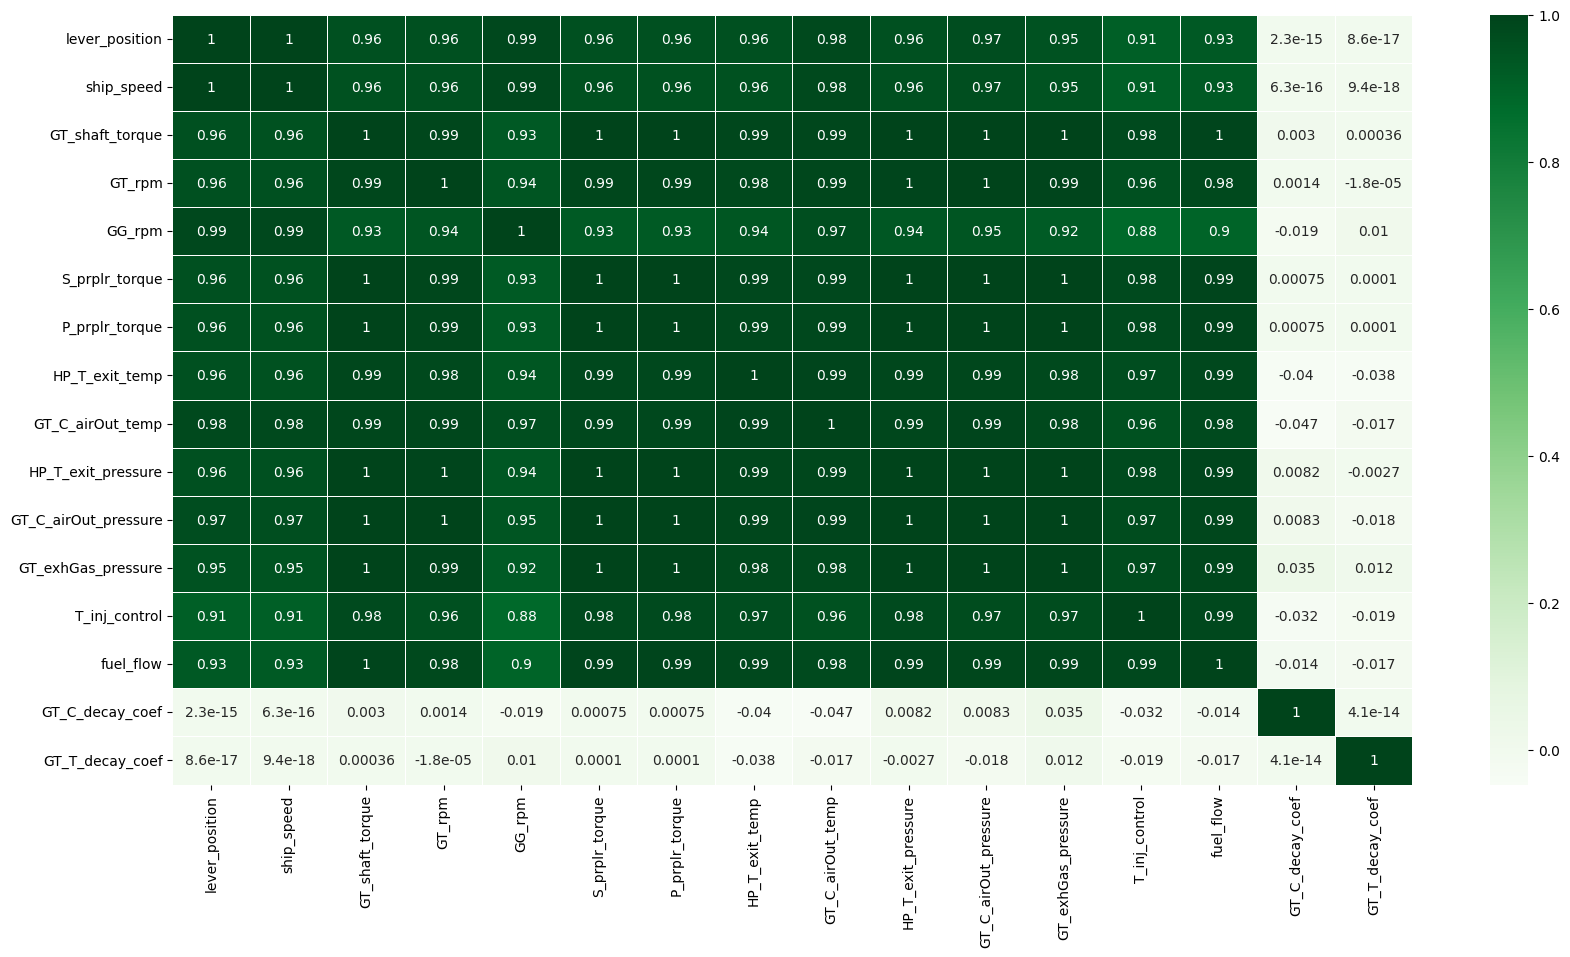

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
_= sns.heatmap(df.corr(), cmap = 'Greens', linewidth=0.5, annot=True)

Como as features tem uma alta correlação entre elas e uma baixa entre as respostas podemos assumir que as features e as respostas possuem uma não-linearidade entre si. 

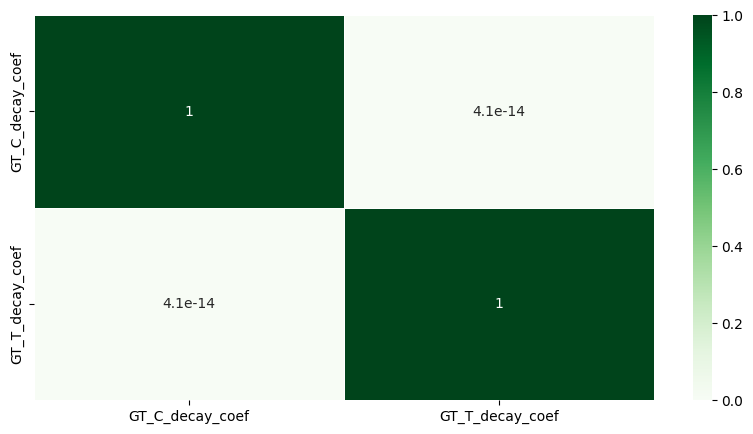

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
_= sns.heatmap(df.iloc[: , -2:].corr(), cmap = 'Greens', linewidth=0.5, annot=True)

Como as respostas também possuem uma baixa correlação entre si, iremos considerá-las independentes, com isso, usá-las em treinos diferentes

# Limpeza dos Dados

In [16]:
try:
  f1 = 'GT_C_airIn_temp'
  f2 = 'GT_C_airIn_pressure'
  df=df.drop(f1, axis=1)
  print('Removida feature ', f1)
  df=df.drop(f2, axis=1)
  print('Removida feature ', f2)
except Exception:
  print('Feature(s) já não se encontram no DataFrame')
  pass

Feature(s) já não se encontram no DataFrame


#Divisão de Dados

## Features e Targets

In [17]:
X = df.iloc[: , :-2]
y1 = df['GT_C_decay_coef']
y2 = df['GT_T_decay_coef']


## Treino e Teste

In [18]:
x1_train,x1_test,y1_train,y1_test = train_test_split(X,y1)
x2_train,x2_test,y2_train,y2_test = train_test_split(X,y2)

# Modelagem e Inferência

## Sugestão de Modelos

* Support Vector Machine Regression; OK
* k-NN; OK
* Decision Tree Regression; OK
* BaggingRegressor; OK
* XGBRegressor; OK
<br><br>
* Neural Net;
* Deep Learning;
<br>


## Modelos Candidatos e Métricas

In [19]:
models = {'SVR' : SVR(),
          'KNeighborsRegressor': KNeighborsRegressor(), 
          'DecisionTreeRegressor': DecisionTreeRegressor(), 
          'BaggingRegressor': BaggingRegressor(), 
          'XGBRegressor': XGBRegressor()}

In [20]:
def train_models(x_train, y_train, x_test, y_test, models):
  _models = deepcopy(models)
  y_info = pd.DataFrame(columns=['Model','Train Time', 'Mean Absolute Error', 'Mean Absolute Percentual Error', 'Mean Squared  Error',
                                 'Root Mean Squared  Error','Train Accuracy (R²)', 'Test Accuracy (R²)', 'Y Predicted Test'], 
                       index = _models.keys())
  
  for i, model in enumerate(_models.keys()):
    start_time = time.perf_counter()
    y_info.loc[y_info.index[i], 'Model'] = _models[model].fit(x_train, y_train)
    y_info.loc[y_info.index[i], 'Train Time'] = time.perf_counter() - start_time
    y_pred = _models[model].predict(x_test)

    y_info.loc[y_info.index[i], 'Train Accuracy (R²)'] = _models[model].score(x_train, y_train)
    y_info.loc[y_info.index[i], 'Test Accuracy (R²)'] = _models[model].score(x_test, y_test)
    y_info.loc[y_info.index[i], 'Mean Absolute Error'] = mean_absolute_error(y_test, y_pred)
    y_info.loc[y_info.index[i], 'Mean Absolute Percentual Error'] = metrics.mean_absolute_percentage_error(y_test, y_pred)
    y_info.loc[y_info.index[i], 'Mean Squared  Error'] = mean_squared_error(y_test, y_pred)
    y_info.loc[y_info.index[i], 'Root Mean Squared  Error'] = np.sqrt(mean_squared_error(y_test, y_pred))
    y_info.loc[y_info.index[i], 'Y Predicted Test'] = y_pred

  return y_info

## Modelos sem Redução de Dimensionalidade

### Modelos para y1

In [21]:
y1_models = train_models(x1_train.values, y1_train, x1_test.values, y1_test, models)
y1_models.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Train Time Mean Absolute Error  \
SVR                       0.0155            0.012527   
KNeighborsRegressor     0.057069            0.001353   
DecisionTreeRegressor   0.280526            0.000998   
BaggingRegressor        1.924294            0.000605   
XGBRegressor            9.567579            0.000939   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.012856            0.000212   
KNeighborsRegressor                         0.001391            0.000013   
DecisionTreeRegressor                       0.001024            0.000002   
BaggingRegressor                             0.00062            0.000001   
XGBRegressor                                0.000963            0.000002   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.014546            -0.00003   
KNeighborsRegressor                   0.003567            0.962603   
DecisionTreeRegressor                 0.001557                 1.0   
BaggingRegressor                      0.001053            0.998782   
XGBRegressor                          0.001289            0.997358   

                      Test Accuracy (R²)  
SVR                            -0.000275  
KNeighborsRegressor              0.93986  
DecisionTreeRegressor           0.988535  
BaggingRegressor                0.994762  
XGBRegressor                    0.992141

### Modelos para y2

In [22]:
y2_models = train_models(x2_train.values, y2_train, x2_test.values, y2_test, models)
y2_models.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Train Time Mean Absolute Error  \
SVR                     0.012633            0.006468   
KNeighborsRegressor     0.027922             0.00103   
DecisionTreeRegressor   0.222904            0.000515   
BaggingRegressor        1.697436            0.000391   
XGBRegressor            4.182556            0.000648   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.006551            0.000056   
KNeighborsRegressor                         0.001043            0.000006   
DecisionTreeRegressor                       0.000522            0.000001   
BaggingRegressor                            0.000396            0.000001   
XGBRegressor                                0.000656            0.000001   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.007462                -0.0   
KNeighborsRegressor                   0.002423            0.921226   
DecisionTreeRegressor                 0.001164                 1.0   
BaggingRegressor                      0.000739            0.997669   
XGBRegressor                          0.000959            0.994587   

                      Test Accuracy (R²)  
SVR                            -0.000002  
KNeighborsRegressor             0.894526  
DecisionTreeRegressor           0.975667  
BaggingRegressor                0.990203  
XGBRegressor                    0.983488

#Y1

## Redução de Dimensionalidade

### Modelos usando Redução de Dimensionalidade por VIF (Sem PCA)

Obtendo a correlação de cada feature com o respectivo target

In [23]:
y1_df_corr = df.corr()['GT_C_decay_coef'].abs().sort_values(ascending=False)
y1_df_corr

GT_C_decay_coef         1.000000e+00
GT_C_airOut_temp        4.717657e-02
HP_T_exit_temp          3.962512e-02
GT_exhGas_pressure      3.528524e-02
T_inj_control           3.203662e-02
GG_rpm                  1.883800e-02
fuel_flow               1.366765e-02
GT_C_airOut_pressure    8.327871e-03
HP_T_exit_pressure      8.167586e-03
GT_shaft_torque         2.978258e-03
GT_rpm                  1.369908e-03
S_prplr_torque          7.535000e-04
P_prplr_torque          7.535000e-04
GT_T_decay_coef         4.064242e-14
lever_position          2.264405e-15
ship_speed              6.346298e-16
Name: GT_C_decay_coef, dtype: float64

Mantendo apenas as features que tem alta correlação relativa com o target <br>
Definindo o threshold para 0.6

In [24]:
y1_features = y1_df_corr[y1_df_corr > 1E-3].index.to_list()[1:]
y1_features

['GT_C_airOut_temp',
 'HP_T_exit_temp',
 'GT_exhGas_pressure',
 'T_inj_control',
 'GG_rpm',
 'fuel_flow',
 'GT_C_airOut_pressure',
 'HP_T_exit_pressure',
 'GT_shaft_torque',
 'GT_rpm']

Checando por MultiColinearidade

In [25]:
def calculate_vif(df, features):
  vif, tolerance = {}, {}

  # As features que queremos examinar
  for feature in features:

    # Extrair todos os outros recursos que iremos regress
    # 
    X_ = [f for f in features if f != feature]
    X_, y_ = df[X_], df[feature]

    # Extrair o r-squared do fit
    r2 = LinearRegression().fit(X_, y_).score(X_, y_)

    # Calcular a tolerância
    tolerance[feature] = 1 - r2

    # Calcular o VIF
    vif[feature] = 1/(tolerance[feature])

    # Retornar o VIF do DataFrame
  return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

y1_calculated_vif = calculate_vif(df, y1_features).abs().sort_values(ascending=True, by=['VIF'])
y1_calculated_vif
  


VIF  Tolerance
T_inj_control            42.164412   0.023717
GG_rpm                  120.697885   0.008285
HP_T_exit_temp          285.371042   0.003504
GT_C_airOut_temp        540.845322   0.001849
GT_rpm                  933.486623   0.001071
GT_exhGas_pressure     1174.156624   0.000852
fuel_flow              1445.078771   0.000692
GT_C_airOut_pressure   4237.105591   0.000236
GT_shaft_torque        5140.510091   0.000195
HP_T_exit_pressure    22654.117814   0.000044

Modelos usando features com VIF menor que 1000

In [26]:
features = y1_calculated_vif[y1_calculated_vif['VIF'] < 1000].index.to_list()
print('Features (VIF < 1000):\n', features)

# Treinando o Modelo com as Features Selecionadas
x1_train_1000 = x1_train.loc[:, features]
x1_test_1000 = x1_test.loc[:, features]

print('\nModelos:')
y1_models_1000 = train_models(x1_train_1000.values, y1_train, x1_test_1000.values, y1_test, models)
y1_models_1000.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Features (VIF < 1000):
 ['T_inj_control', 'GG_rpm', 'HP_T_exit_temp', 'GT_C_airOut_temp', 'GT_rpm']

Modelos:


Train Time Mean Absolute Error  \
SVR                     0.012425            0.012527   
KNeighborsRegressor     0.014192            0.000577   
DecisionTreeRegressor   0.076141            0.001063   
BaggingRegressor        0.565405            0.000651   
XGBRegressor            1.043181            0.000929   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.012856            0.000212   
KNeighborsRegressor                         0.000592            0.000002   
DecisionTreeRegressor                       0.001091            0.000003   
BaggingRegressor                            0.000669            0.000002   
XGBRegressor                                0.000953            0.000002   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.014546            -0.00003   
KNeighborsRegressor                   0.001382            0.994929   
DecisionTreeRegressor                 0.001851                 1.0   
BaggingRegressor                      0.001349            0.997432   
XGBRegressor                          0.001405            0.997636   

                      Test Accuracy (R²)  
SVR                            -0.000275  
KNeighborsRegressor             0.990974  
DecisionTreeRegressor           0.983811  
BaggingRegressor                0.991397  
XGBRegressor                    0.990666

Modelos usando features com VIF menor que 500

In [27]:
features = y1_calculated_vif[y1_calculated_vif['VIF'] < 500].index.to_list()
print('Features (VIF < 500):\n', features)

# Treinando o Modelo com as Features Selecionadas
x1_train_500 = x1_train.loc[:, features]
x1_test_500 = x1_test.loc[:, features]

print('\nModelos:')
y1_models_500 = train_models(x1_train_500.values, y1_train, x1_test_500.values, y1_test, models)
y1_models_500.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Features (VIF < 500):
 ['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']

Modelos:


Train Time Mean Absolute Error  \
SVR                     0.003494            0.012527   
KNeighborsRegressor     0.004943             0.00071   
DecisionTreeRegressor   0.054057            0.001262   
BaggingRegressor         0.38585            0.000777   
XGBRegressor            0.765657            0.001248   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.012856            0.000212   
KNeighborsRegressor                         0.000728            0.000004   
DecisionTreeRegressor                       0.001295            0.000005   
BaggingRegressor                            0.000796            0.000003   
XGBRegressor                                0.001279            0.000005   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.014546            -0.00003   
KNeighborsRegressor                   0.001982             0.98552   
DecisionTreeRegressor                 0.002306                 1.0   
BaggingRegressor                      0.001825            0.995579   
XGBRegressor                          0.002141            0.993966   

                      Test Accuracy (R²)  
SVR                            -0.000275  
KNeighborsRegressor             0.981433  
DecisionTreeRegressor           0.974866  
BaggingRegressor                0.984249  
XGBRegressor                    0.978325

Modelos usando features com VIF menor que 250

In [28]:
features = y1_calculated_vif[y1_calculated_vif['VIF'] < 250].index.to_list()
print('Features (VIF < 250):\n', features)

# Treinando o Modelo com as Features Selecionadas
x1_train_250 = x1_train.loc[:, features]
x1_test_250 = x1_test.loc[:, features]

print('\nModelos:')
y1_models_250 = train_models(x1_train_250.values, y1_train, x1_test_250.values, y1_test, models)
y1_models_250.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Features (VIF < 250):
 ['T_inj_control', 'GG_rpm']

Modelos:


Train Time Mean Absolute Error  \
SVR                     0.003732            0.012527   
KNeighborsRegressor     0.003811             0.00231   
DecisionTreeRegressor   0.035892            0.002186   
BaggingRegressor        0.278567            0.001523   
XGBRegressor            0.560691            0.001889   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.012856            0.000212   
KNeighborsRegressor                         0.002369            0.000015   
DecisionTreeRegressor                       0.002242            0.000026   
BaggingRegressor                            0.001562            0.000014   
XGBRegressor                                0.001937            0.000013   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.014546            -0.00003   
KNeighborsRegressor                   0.003895            0.938036   
DecisionTreeRegressor                 0.005091            0.999998   
BaggingRegressor                      0.003739             0.98253   
XGBRegressor                          0.003547            0.973213   

                      Test Accuracy (R²)  
SVR                            -0.000275  
KNeighborsRegressor             0.928269  
DecisionTreeRegressor           0.877466  
BaggingRegressor                0.933921  
XGBRegressor                     0.94054

###PCA de todas as Features

Precisamos aplicar o Standardization antes de utilizar o PCA

In [29]:
# Performing Standardization
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

Analisando o Principal Component Analysis (PCA)

In [30]:
components = None 
# None return the same number of original features in the dataset
# floating number between 0<n<1 return the number of components needed to capture the specified percentage of variability in the data
# an integer to indicate how many principal componentes you want to reduce the features to.

pca = PCA(n_components = components)

# Perform PCA on the scaled data
pca.fit(X_scaled)

print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)

Variances (Percentage):
[9.75354433e+01 1.82261150e+00 2.48912686e-01 1.58823802e-01
 1.38784127e-01 6.88731250e-02 1.70245538e-02 5.12306744e-03
 2.32578917e-03 1.17974583e-03 6.84937966e-04 1.26871934e-04
 8.64557484e-05 3.27970454e-32]


* Vemos que o primeiro componentes captura 97.7% de variabilidade nos dados
* O segundo 1.8%
* Todos os componentes completam 100%

Text(0, 0.5, 'Explained variance (%)')

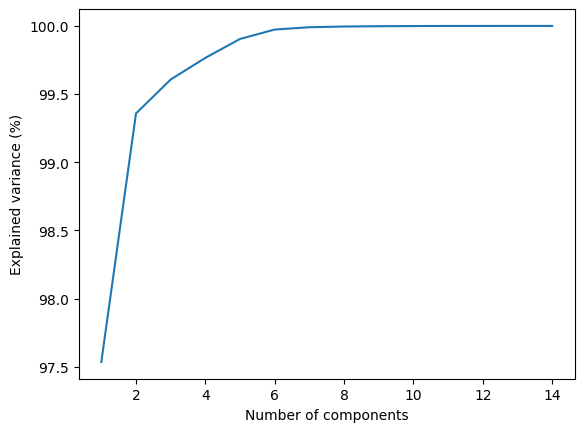

In [31]:
components = len(pca.explained_variance_ratio_) if components is None else components
plt.plot(range(1, components+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

####Aplicando o PCA

In [32]:
pca_components = abs(pca.components_)

In [33]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))

components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

print('\nThe most important features in each component')

for row in range(pca_components.shape[0]): # get the indices of the top 4 values in each row
  temp = np.argpartition(-(pca_components[row]),6)
  # sort the indices in descending order
  indices = temp[np.argsort((-pca_components[row])[temp])][:6]

  # print the top 4 feature names
  print(f'Component {row}: {df.columns[indices].to_list()}')


Cumulative Variances (Percentage):
[97.53544334 99.35805484 99.60696752]
Number of components: 3

The most important features in each component
Component 0: ['GT_C_airOut_pressure', 'HP_T_exit_pressure', 'GT_shaft_torque', 'GT_C_airOut_temp', 'S_prplr_torque', 'P_prplr_torque']
Component 1: ['GG_rpm', 'ship_speed', 'lever_position', 'T_inj_control', 'fuel_flow', 'GT_exhGas_pressure']
Component 2: ['T_inj_control', 'GT_rpm', 'HP_T_exit_temp', 'GT_exhGas_pressure', 'HP_T_exit_pressure', 'GT_C_airOut_pressure']
Component 3: ['HP_T_exit_temp', 'T_inj_control', 'ship_speed', 'lever_position', 'GT_C_airOut_temp', 'fuel_flow']
Component 4: ['GT_rpm', 'GG_rpm', 'T_inj_control', 'lever_position', 'ship_speed', 'S_prplr_torque']
Component 5: ['GG_rpm', 'GT_rpm', 'S_prplr_torque', 'P_prplr_torque', 'ship_speed', 'lever_position']
Component 6: ['GT_C_airOut_temp', 'GT_exhGas_pressure', 'HP_T_exit_temp', 'GT_rpm', 'S_prplr_torque', 'P_prplr_torque']
Component 7: ['GT_C_airOut_temp', 'GT_exhGas_pres

####Modelagem

In [34]:
# Splitando os dados em treino e teste
X_pca2_train, X_pca2_test, y1_pca2_train, y1_pca2_test = train_test_split(X_pca,y1)

In [35]:
# Aplicando os modelos
y1_models_pca = train_models(X_pca2_train, y1_pca2_train, X_pca2_test, y1_pca2_test, models)
y1_models_pca.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Train Time Mean Absolute Error  \
SVR                     0.004444            0.012547   
KNeighborsRegressor      0.02869            0.001063   
DecisionTreeRegressor   0.039371            0.001855   
BaggingRegressor        0.300154            0.001208   
XGBRegressor            0.859266            0.001613   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.012873            0.000212   
KNeighborsRegressor                          0.00109            0.000005   
DecisionTreeRegressor                       0.001902             0.00001   
BaggingRegressor                            0.001239            0.000005   
XGBRegressor                                0.001654            0.000006   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.014564           -0.000004   
KNeighborsRegressor                   0.002184            0.989055   
DecisionTreeRegressor                 0.003116                 1.0   
BaggingRegressor                      0.002281            0.996257   
XGBRegressor                          0.002512            0.993176   

                      Test Accuracy (R²)  
SVR                            -0.000035  
KNeighborsRegressor             0.977515  
DecisionTreeRegressor           0.954235  
BaggingRegressor                0.975462  
XGBRegressor                    0.970259

Consideramos menos vantajoso, pois precisa de bastante features

####Y2 - Aguardando Desenvolvimento

In [36]:
y2_df_corr = df.corr()['GT_T_decay_coef'].abs().sort_values(ascending=False)
y2_df_corr

GT_T_decay_coef         1.000000e+00
HP_T_exit_temp          3.846390e-02
T_inj_control           1.887184e-02
GT_C_airOut_pressure    1.830336e-02
fuel_flow               1.732675e-02
GT_C_airOut_temp        1.685505e-02
GT_exhGas_pressure      1.179423e-02
GG_rpm                  1.000011e-02
HP_T_exit_pressure      2.718186e-03
GT_shaft_torque         3.576383e-04
S_prplr_torque          1.044235e-04
P_prplr_torque          1.044235e-04
GT_rpm                  1.776556e-05
GT_C_decay_coef         4.064242e-14
lever_position          8.566427e-17
ship_speed              9.367920e-18
Name: GT_T_decay_coef, dtype: float64

###PCA do Top VIF

In [37]:
features = y1_calculated_vif[y1_calculated_vif['VIF'] < 500].index.to_list()
print('Features (VIF < 500):\n', features)

x1_pca_500 = X.loc[:, features]



Features (VIF < 500):
 ['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']


In [38]:
# Performing Standardization
sc = StandardScaler()
X_scaled = sc.fit_transform(x1_pca_500)

In [39]:
components = 2
# None return the same number of original features in the dataset
# floating number between 0<n<1 return the number of components needed to capture the specified percentage of variability in the data
# an integer to indicate how many principal componentes you want to reduce the features to.

pca = PCA(n_components = components)

# Perform PCA on the scaled data
pca.fit(X_scaled)

print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)

Variances (Percentage):
[95.31759907  4.1212367 ]


Text(0, 0.5, 'Explained variance (%)')

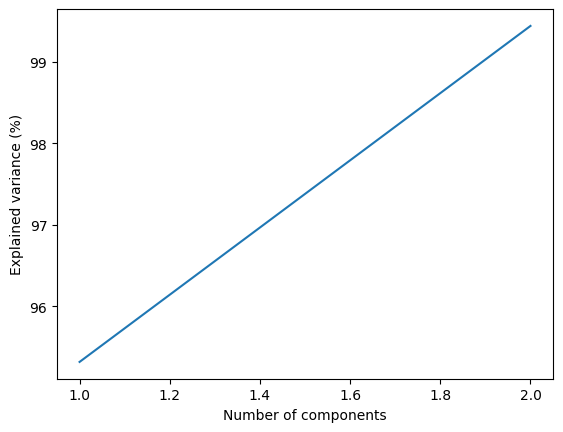

In [40]:
components = len(pca.explained_variance_ratio_) if components is None else components
plt.plot(range(1, components+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

####Aplicando o PCA

In [41]:
pca_components = abs(pca.components_)
print(pca_components)

[[0.57537144 0.56895791 0.58756669]
 [0.62773132 0.76771713 0.12870039]]


In [42]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))

components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

print('\nThe most important features in each component')

for row in range(pca_components.shape[0]): # get the indices of the top 4 values in each row
  temp = np.argpartition(-(pca_components[row]),2)
  # sort the indices in descending order
  indices = temp[np.argsort((-pca_components[row])[temp])][:]

  # print the top 4 feature names
  print(f'Component {row}: {df.columns[indices].to_list()}')

Cumulative Variances (Percentage):
[95.31759907 99.43883577]
Number of components: 2

The most important features in each component
Component 0: ['GT_shaft_torque', 'lever_position', 'ship_speed']
Component 1: ['ship_speed', 'lever_position', 'GT_shaft_torque']


####Modelagem

In [43]:
#sc = StandardScaler()
#X_scaled = sc.fit_transform(x1_pca_500)

#pca = PCA(n_components=2)
#X_pca = pca.fit_transform(X_scaled)

# Splitando os dados em traino e teste
X_pca2_train, X_pca2_test, y1_pca2_train, y1_pca2_test = train_test_split(X_pca,y1)

Redução de Dimensão e PCA

In [44]:
# Aplicando os modelos
y1_PCA2_500_models = train_models(X_pca2_train, y1_pca2_train, X_pca2_test, y1_pca2_test, models)
y1_PCA2_500_models.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Train Time Mean Absolute Error  \
SVR                     0.004447            0.012772   
KNeighborsRegressor     0.006646            0.001853   
DecisionTreeRegressor    0.03772            0.002904   
BaggingRegressor        0.255136            0.002122   
XGBRegressor            0.614868            0.002805   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.013113            0.000217   
KNeighborsRegressor                         0.001901            0.000022   
DecisionTreeRegressor                       0.002982            0.000039   
BaggingRegressor                            0.002177            0.000023   
XGBRegressor                                0.002878            0.000026   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.014748           -0.000073   
KNeighborsRegressor                   0.004647            0.935711   
DecisionTreeRegressor                 0.006283                 1.0   
BaggingRegressor                      0.004828            0.979665   
XGBRegressor                          0.005071            0.961667   

                      Test Accuracy (R²)  
SVR                            -0.000652  
KNeighborsRegressor             0.900655  
DecisionTreeRegressor           0.818348  
BaggingRegressor                0.892742  
XGBRegressor                    0.881685

Redução de Dimensão sem PCA apenas para comparação

In [45]:
y1_models_500.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Train Time Mean Absolute Error  \
SVR                     0.003494            0.012527   
KNeighborsRegressor     0.004943             0.00071   
DecisionTreeRegressor   0.054057            0.001262   
BaggingRegressor         0.38585            0.000777   
XGBRegressor            0.765657            0.001248   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.012856            0.000212   
KNeighborsRegressor                         0.000728            0.000004   
DecisionTreeRegressor                       0.001295            0.000005   
BaggingRegressor                            0.000796            0.000003   
XGBRegressor                                0.001279            0.000005   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.014546            -0.00003   
KNeighborsRegressor                   0.001982             0.98552   
DecisionTreeRegressor                 0.002306                 1.0   
BaggingRegressor                      0.001825            0.995579   
XGBRegressor                          0.002141            0.993966   

                      Test Accuracy (R²)  
SVR                            -0.000275  
KNeighborsRegressor             0.981433  
DecisionTreeRegressor           0.974866  
BaggingRegressor                0.984249  
XGBRegressor                    0.978325

O resultado foi levemente menor.

Seguiremos com os modelos obtidos no y1_models_500 <br>
KNeighborsRegressor e BaggingRegressor

##Modelos Definidos

In [46]:
y1_pred_bagg_500 = y1_models_500['Y Predicted Test']['BaggingRegressor']
y1_pred_knn_500 = y1_models_500['Y Predicted Test']['KNeighborsRegressor']

In [47]:
x_columns_500 = list(x1_test_500)
x_columns_500

['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']

## Visualização das Predições

In [48]:
def Graph_prediction2d(x_train, y_train, x_test, y_test, y_pred):

  for i, x in enumerate(x_train):
    fig = go.Figure([
        go.Scatter(x=x_train.iloc[:,i], y=y_train, name='Train', mode='markers'),
        go.Scatter(x=x_test.iloc[:,i], y=y_test, name='Test', mode='markers'),
        go.Scatter(x=x_test.iloc[:,i], y=y_pred, name='Prediction', mode='markers')
    ])

    fig.update_layout(title=X.columns[i] +  ' x Target',
                      
                        xaxis_title=X.columns[i],
                        yaxis_title='y',
                        
                      width=600, height=500)
    fig.show()

In [49]:
print('KNeighborsRegressor')
Graph_prediction2d(x1_train[x_columns_500], y1_train, x1_test[x_columns_500], y1_test, y1_pred_knn_500)

KNeighborsRegressor


In [50]:
print('BaggingRegressor')
Graph_prediction2d(x1_train[x_columns_500], y1_train, x1_test[x_columns_500], y1_test, y1_pred_bagg_500)

BaggingRegressor


https://github.com/plotly/plotly.py/issues/1085
https://www.google.com/search?q=go.Scatter3d+with+colorbar&source=lmns&bih=969&biw=1920&rlz=1C1GCEU_pt-PTBR940BR940&hl=pt-BR&sa=X&ved=2ahUKEwiowNjogcj6AhWNrJUCHY7nBtkQ_AUoAHoECAEQAA


In [51]:
def Graph_prediction3d(x, y_test, y_pred):
  x_ = x.iloc[:,0]
  z_ = x.iloc[:,1]
  y_ = x.iloc[:,2]

  # plotly data
  data=[go.Scatter3d(x=x_, y=y_, z=z_,mode='markers',
        marker=dict(
          size=7,
          color=y_test,
          #colorscale='Viridis',
          opacity=0.5,
          symbol='diamond')), # 'circle', 'circle-open', 'cross',
                      # 'diamond', 'diamond-open', 'square', 'square-open', 'x'

        go.Scatter3d(x=x_, y=y_, z=z_,mode='markers',
        marker=dict(
          size=5,
          color=y_pred,
          #colorscale='icefire',
          opacity=1,
          symbol='circle'))]

  fig = go.Figure(data)
  fig.update_layout(title='Main Features x Target',
                    scene=dict(
                    xaxis_title=X.columns[0],
                    yaxis_title=X.columns[1],
                    zaxis_title=X.columns[2]),          
                    width=700, height=700)

  fig.show()

In [52]:
print('KNeighborsRegressor')
Graph_prediction3d(x1_test[x_columns_500], y1_test, y1_pred_knn_500)

KNeighborsRegressor


In [53]:
print('BaggingRegressor')
Graph_prediction3d(x1_test[x_columns_500], y1_test, y1_pred_bagg_500)

BaggingRegressor


In [54]:
fig = px.scatter_3d(x=x1_test[x_columns_500].iloc[:,0], y=x1_test[x_columns_500].iloc[:,2], z=x1_test[x_columns_500].iloc[:,1],  color=y1_test)
fig.show()

## Aprimoramento dos Hiperparâmetros

###KNN

In [55]:
param_grid_knn = {
    'n_neighbors': range(1,19,2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    #'algorithm': [auto, 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(15,40,5)
}

#### Grid Search

In [56]:
gs = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_knn,
    verbose=1,
    cv = 3,
    n_jobs = -1
)

gs_knn_results = gs.fit(x1_train_500.values, y1_train)

Fitting 3 folds for each of 270 candidates, totalling 810 fits


####Bayesian Optimization

In [57]:
def objective_knn(trial):
  """return the R² Score"""
  x_train = x1_train_500
  y_train = y1_train
  x_test = x1_test_500
  y_test = y1_test
  # search space 
  param_obj_knn = {
      'n_neighbors': trial.suggest_int('n_neighbors', low=1, high=19, step=2),
      'leaf_size': trial.suggest_int('leaf_size', low=15, high=40, step=5),
      'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
      'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
  }

  knn = KNeighborsRegressor(**param_obj_knn)
  
  knn.fit(x_train, y_train)
  score = knn.score(x_test, y_test)
  return score

In [58]:
# create a study (aim to maximize score)
study = optuna.create_study(sampler=TPESampler(), direction='maximize')

time_start = time.time()
study.optimize(objective_knn, n_trials=100)
time_bayesian = time.time() - time_start

[I 2023-04-01 23:15:24,183] A new study created in memory with name: no-name-5205fc43-a764-4dc2-a88a-95c4bdfb9194
[I 2023-04-01 23:15:24,229] Trial 0 finished with value: 0.9756265749898909 and parameters: {'n_neighbors': 1, 'leaf_size': 40, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.9756265749898909.
[I 2023-04-01 23:15:24,274] Trial 1 finished with value: 0.9643022197207024 and parameters: {'n_neighbors': 17, 'leaf_size': 40, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.9756265749898909.
[I 2023-04-01 23:15:24,312] Trial 2 finished with value: 0.9643022197207024 and parameters: {'n_neighbors': 17, 'leaf_size': 30, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.9756265749898909.
[I 2023-04-01 23:15:24,344] Trial 3 finished with value: 0.9756265749898908 and parameters: {'n_neighbors': 1, 'leaf_size': 20, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.9756265749898

In [59]:
# Default
default_knn_model = y1_models_500['Model']['KNeighborsRegressor']

#Gs
gs_knn_model = gs_knn_results.best_estimator_

#Bay
bay_knn_model = KNeighborsRegressor(**study.best_trial.params)
bay_knn_model.fit(x1_train_500.values, y1_train)


KNeighborsRegressor(leaf_size=15, metric='manhattan', n_neighbors=3,
                    weights='distance')

In [60]:
pd.DataFrame([default_knn_model.get_params(),
              gs_knn_model.get_params(),
              bay_knn_model.get_params()],
              index=[
                  'KNN Default',
                  'KNN Grid Search',
                  'KNN Bayesian Optimization'])

algorithm  leaf_size     metric metric_params  \
KNN Default                    auto         30  minkowski          None   
KNN Grid Search                auto         15  manhattan          None   
KNN Bayesian Optimization      auto         15  manhattan          None   

                          n_jobs  n_neighbors  p   weights  
KNN Default                 None            5  2   uniform  
KNN Grid Search             None            3  2  distance  
KNN Bayesian Optimization   None            3  2  distance

In [61]:
optuna.visualization.plot_param_importances(study)

In [62]:
models_knn = {
    'KNN Default': default_knn_model,
    'KNN Grid Search': gs_knn_model,
    'KNN Bayesian Optimization ': bay_knn_model
}

In [63]:
def metrics_models(x_train, y_train, x_test, y_test, models):
  y_info = pd.DataFrame(columns=['Model', 'Mean Absolute Error', 'Mean Absolute Percentual Error', 'Mean Squared  Error',
                                 'Root Mean Squared  Error','Train Accuracy (R²)', 'Test Accuracy (R²)', 'Y Predicted Test'], 
                       index = models.keys())
  
  for i, model in enumerate(models.keys()):
    y_pred = models[model].predict(x_test)
    
    #y_info.loc[y_info.index[i], 'Model'] = models[model].fit(x_train, y_train)
    y_info.loc[y_info.index[i], 'Train Accuracy (R²)'] = models[model].score(x_train, y_train)
    y_info.loc[y_info.index[i], 'Test Accuracy (R²)'] = models[model].score(x_test, y_test)
    y_info.loc[y_info.index[i], 'Mean Absolute Error'] = mean_absolute_error(y_test, y_pred)
    y_info.loc[y_info.index[i], 'Mean Absolute Percentual Error'] = metrics.mean_absolute_percentage_error(y_test, y_pred)
    y_info.loc[y_info.index[i], 'Mean Squared  Error'] = mean_squared_error(y_test, y_pred)
    y_info.loc[y_info.index[i], 'Root Mean Squared  Error'] = np.sqrt(mean_squared_error(y_test, y_pred))
    #y_info.loc[y_info.index[i], 'Y Predicted Test'] = y_pred

  return y_info

In [64]:
y1_metrics_models_knn = metrics_models(x1_train_500.values, y1_train, x1_test_500.values, y1_test, models_knn)
y1_metrics_models_knn.drop('Y Predicted Test', axis=1).drop('Model', axis=1)

Mean Absolute Error Mean Absolute Percentual Error  \
KNN Default                            0.00071                       0.000728   
KNN Grid Search                       0.000664                       0.000681   
KNN Bayesian Optimization             0.000664                       0.000681   

                           Mean Squared  Error Root Mean Squared  Error  \
KNN Default                           0.000004                 0.001982   
KNN Grid Search                       0.000003                 0.001635   
KNN Bayesian Optimization             0.000003                 0.001635   

                           Train Accuracy (R²) Test Accuracy (R²)  
KNN Default                            0.98552           0.981433  
KNN Grid Search                            1.0           0.987359  
KNN Bayesian Optimization                  1.0           0.987359

###BaggingRegressor

In [65]:
param_grid_bagg = {
    'n_estimators': range(0,51,5),
    'max_samples' : [0.6, 0.8, 1.0],
    'max_features': [0.6, 0.8, 1.0],
    #'bootstrap': [True, False],
    #'oob_score': [True, False],
    #'bootstrap_features': [True, False],
    'warm_start': [True, False],
    #'base_estimator': [DecisionTreeRegressor()], #default = DecisionTreeRegressor
    #'base_estimator__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    #'base_estimator__splitter': ['best','random'],
    #'base_estimator__max_depth': range(1,13,2),
    #'base_estimator__min_samples_leaf': range(1,10,1),
    #'base_estimator__min_weight_fraction_leaf': [x * 0.1 for x in range(0, 11)],
    #'base_estimator__max_features': ['auto','log2','sqrt',None],
    #'base_estimator__max_leaf_nodes' : [None] + [*range(10,100,10)]
}

####Grid Search

In [66]:
y1_gs = GridSearchCV(
    BaggingRegressor(),
    param_grid_bagg,
    verbose=1,
    cv = 3,
    n_jobs = -1
)

y1_gs_bagg_results = gs.fit(x1_train_500.values, y1_train.values)

Fitting 3 folds for each of 270 candidates, totalling 810 fits


####Bayesian Optimization

In [67]:
def objective_bagg(trial):
  """return the R² Score"""
  x_train = x1_train_500
  y_train = y1_train
  x_test = x1_test_500
  y_test = y1_test
  # search space
  param_obj_bagg = {
      'n_estimators': trial.suggest_categorical('n_estimators', range(1,51,5)),
      'max_samples' : trial.suggest_categorical('max_samples', [0.6, 0.8, 1.0]),
      'max_features': trial.suggest_categorical('max_features', [0.6, 0.8, 1.0]),

      'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
      #'oob_score': trial.suggest_categorical('oob_score', [True, False]),
      'bootstrap_features': trial.suggest_categorical('bootstrap_features', [True, False]),
      'warm_start': trial.suggest_categorical('warm_start', [True, False]),

      #'base_estimator': trial.suggest_categorical('base_estimator', [DecisionTreeRegressor()]),
      #'base_estimator__criterion': trial.suggest_categorical('base_estimator__criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
      #'base_estimator__splitter': trial.suggest_categorical('base_estimator__splitter', ['best','random']),
      #'base_estimator__max_depth': trial.suggest_int('base_estimator__max_depth', low=1, high=13, step=2),
      #'base_estimator__min_samples_leaf': trial.suggest_int('base_estimator__min_samples_leaf', low=1, high=10, step=1),
      #'base_estimator__min_weight_fraction_leaf': trial.suggest_int('base_estimator__min_weight_fraction_leaf', low=0.1, high=1.0, step=0.1),
      #'base_estimator__max_features': trial.suggest_categorical('base_estimator__max_features', ['auto','log2','sqrt',None]),
      #'base_estimator__max_leaf_nodes' : trial.suggest_categorical('base_estimator__max_leaf_nodes', [None,10,20,30,40,50,60,70,80,90]) 

  }

  bagg = BaggingRegressor(**param_obj_bagg)
  
  bagg.fit(x_train, y_train)
  score = bagg.score(x_test, y_test)
  return score

In [68]:
# create a study (aim to maximize score)
y1_study_bagg = optuna.create_study(sampler=TPESampler(), direction='maximize')

time_start = time.time()
y1_study_bagg.optimize(objective_bagg, n_trials=100)
time_bayesian_bagg = time.time() - time_start

[I 2023-04-01 23:15:44,001] A new study created in memory with name: no-name-07c52ad2-6dda-48b5-ab8d-7867b082c2db
[I 2023-04-01 23:15:44,515] Trial 0 finished with value: 0.4916074758029725 and parameters: {'n_estimators': 36, 'max_samples': 0.6, 'max_features': 0.6, 'bootstrap': True, 'bootstrap_features': False, 'warm_start': True}. Best is trial 0 with value: 0.4916074758029725.
[I 2023-04-01 23:15:45,306] Trial 1 finished with value: 0.9380936411647004 and parameters: {'n_estimators': 21, 'max_samples': 0.8, 'max_features': 0.8, 'bootstrap': False, 'bootstrap_features': False, 'warm_start': True}. Best is trial 1 with value: 0.9380936411647004.
[I 2023-04-01 23:15:46,676] Trial 2 finished with value: 0.9859636935594221 and parameters: {'n_estimators': 41, 'max_samples': 0.8, 'max_features': 1.0, 'bootstrap': True, 'bootstrap_features': False, 'warm_start': False}. Best is trial 2 with value: 0.9859636935594221.
[I 2023-04-01 23:15:46,718] Trial 3 finished with value: -0.20461048935

In [69]:
y1_default_bagg_model = y1_models_500['Model']['BaggingRegressor']

y1_gs_bagg_model = y1_gs_bagg_results.best_estimator_

y1_bay_bagg_model = BaggingRegressor(**y1_study_bagg.best_trial.params)
y1_bay_bagg_model.fit(x1_train_500.values, y1_train.values)

BaggingRegressor(bootstrap=False, max_samples=0.8, n_estimators=46)

In [70]:
y1_models_bagg = {
    'Bagg Default': y1_default_bagg_model,
    'Bagg Grid Search': y1_gs_bagg_model,
    'Bagg Bayesian Optimization ': y1_bay_bagg_model
}

y1_metrics_models_bagg = metrics_models(x1_train_500.values, y1_train.values, x1_test_500.values, y1_test.values, y1_models_bagg)
y1_metrics_models_bagg.drop('Y Predicted Test', axis=1).drop('Model', axis=1)

Mean Absolute Error  \
Bagg Default                           0.000777   
Bagg Grid Search                       0.000664   
Bagg Bayesian Optimization             0.000714   

                            Mean Absolute Percentual Error  \
Bagg Default                                      0.000796   
Bagg Grid Search                                  0.000681   
Bagg Bayesian Optimization                        0.000733   

                            Mean Squared  Error Root Mean Squared  Error  \
Bagg Default                           0.000003                 0.001825   
Bagg Grid Search                       0.000003                 0.001635   
Bagg Bayesian Optimization             0.000003                 0.001655   

                            Train Accuracy (R²) Test Accuracy (R²)  
Bagg Default                           0.995579           0.984249  
Bagg Grid Search                            1.0           0.987359  
Bagg Bayesian Optimization             0.998885           0.987044

In [71]:
optuna.visualization.plot_param_importances(y1_study_bagg)

## Conclusão

Modelos ordenados do melhor para o pior Test Accuracy (R²)

In [72]:
y1_metrics_models = y1_metrics_models_knn.append(y1_metrics_models_bagg).sort_values('Test Accuracy (R²)', ascending=False)
y1_metrics_models.drop('Y Predicted Test', axis=1).drop('Model', axis=1)

<ipython-input-72-41377e5f4c56>:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Mean Absolute Error  \
KNN Grid Search                        0.000664   
KNN Bayesian Optimization              0.000664   
Bagg Grid Search                       0.000664   
Bagg Bayesian Optimization             0.000714   
Bagg Default                           0.000777   
KNN Default                             0.00071   

                            Mean Absolute Percentual Error  \
KNN Grid Search                                   0.000681   
KNN Bayesian Optimization                         0.000681   
Bagg Grid Search                                  0.000681   
Bagg Bayesian Optimization                        0.000733   
Bagg Default                                      0.000796   
KNN Default                                       0.000728   

                            Mean Squared  Error Root Mean Squared  Error  \
KNN Grid Search                        0.000003                 0.001635   
KNN Bayesian Optimization              0.000003                 0.001635   
Bagg Grid Search                       0.000003                 0.001635   
Bagg Bayesian Optimization             0.000003                 0.001655   
Bagg Default                           0.000003                 0.001825   
KNN Default                            0.000004                 0.001982   

                            Train Accuracy (R²) Test Accuracy (R²)  
KNN Grid Search                             1.0           0.987359  
KNN Bayesian Optimization                   1.0           0.987359  
Bagg Grid Search                            1.0           0.987359  
Bagg Bayesian Optimization             0.998885           0.987044  
Bagg Default                           0.995579           0.984249  
KNN Default                             0.98552           0.981433

In [73]:
y1_final_model = y1_bay_bagg_model

# Y2

## Redução de Dimensionalidade

### Modelos usando Redução de Dimensionalidade por VIF (Sem PCA)

Obtendo a correlação de cada feature com o respectivo target

In [74]:
y2_df_corr = df.corr()['GT_T_decay_coef'].abs().sort_values(ascending=False)
y2_df_corr

GT_T_decay_coef         1.000000e+00
HP_T_exit_temp          3.846390e-02
T_inj_control           1.887184e-02
GT_C_airOut_pressure    1.830336e-02
fuel_flow               1.732675e-02
GT_C_airOut_temp        1.685505e-02
GT_exhGas_pressure      1.179423e-02
GG_rpm                  1.000011e-02
HP_T_exit_pressure      2.718186e-03
GT_shaft_torque         3.576383e-04
S_prplr_torque          1.044235e-04
P_prplr_torque          1.044235e-04
GT_rpm                  1.776556e-05
GT_C_decay_coef         4.064242e-14
lever_position          8.566427e-17
ship_speed              9.367920e-18
Name: GT_T_decay_coef, dtype: float64

Mantendo apenas as features que tem alta correlação relativa com o target <br>
Definindo o threshold para 0.6

In [75]:
y2_features = y2_df_corr[y2_df_corr > 1E-3].index.to_list()[1:]
y2_features

['HP_T_exit_temp',
 'T_inj_control',
 'GT_C_airOut_pressure',
 'fuel_flow',
 'GT_C_airOut_temp',
 'GT_exhGas_pressure',
 'GG_rpm',
 'HP_T_exit_pressure']

Checando por MultiColinearidade

In [76]:
y2_calculated_vif = calculate_vif(df, y2_features).abs().sort_values(ascending=True, by=['VIF'])
y2_calculated_vif

VIF  Tolerance
T_inj_control           38.582925   0.025918
GG_rpm                  83.579730   0.011965
HP_T_exit_temp         278.258067   0.003594
GT_C_airOut_temp       499.501339   0.002002
fuel_flow             1092.334108   0.000915
GT_exhGas_pressure    1151.179197   0.000869
GT_C_airOut_pressure  3408.864931   0.000293
HP_T_exit_pressure    9689.136353   0.000103

Modelos usando features com VIF menor que 1000

In [77]:
features = y2_calculated_vif[y2_calculated_vif['VIF'] < 1000].index.to_list()
print('Features (VIF < 1000):\n', features)

# Treinando o Modelo com as Features Selecionadas
x2_train_1000 = x2_train.loc[:, features]
x2_test_1000 = x2_test.loc[:, features]

print('\nModelos:')
y2_models_1000 = train_models(x2_train_1000.values, y2_train, x2_test_1000.values, y2_test, models)
y2_models_1000.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Features (VIF < 1000):
 ['T_inj_control', 'GG_rpm', 'HP_T_exit_temp', 'GT_C_airOut_temp']

Modelos:


Train Time Mean Absolute Error  \
SVR                     0.012086            0.006468   
KNeighborsRegressor     0.021505            0.000464   
DecisionTreeRegressor   0.061147            0.000851   
BaggingRegressor        0.495391            0.000514   
XGBRegressor            0.737686            0.000842   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.006551            0.000056   
KNeighborsRegressor                          0.00047            0.000001   
DecisionTreeRegressor                       0.000862            0.000002   
BaggingRegressor                            0.000521            0.000001   
XGBRegressor                                0.000853            0.000001   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.007462                -0.0   
KNeighborsRegressor                   0.001026            0.984548   
DecisionTreeRegressor                 0.001463                 1.0   
BaggingRegressor                      0.001031            0.995092   
XGBRegressor                          0.001193            0.991129   

                      Test Accuracy (R²)  
SVR                            -0.000002  
KNeighborsRegressor             0.981085  
DecisionTreeRegressor           0.961578  
BaggingRegressor                0.980893  
XGBRegressor                    0.974437

Modelos usando features com VIF menor que 500

In [78]:
features = y2_calculated_vif[y2_calculated_vif['VIF'] < 500].index.to_list()
print('Features (VIF < 500):\n', features)

# Treinando o Modelo com as Features Selecionadas
x2_train_500 = x2_train.loc[:, features]
x2_test_500 = x2_test.loc[:, features]

print('\nModelos:')
y2_models_500 = train_models(x2_train_500.values, y2_train, x2_test_500.values, y2_test, models)
y2_models_500.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Features (VIF < 500):
 ['T_inj_control', 'GG_rpm', 'HP_T_exit_temp', 'GT_C_airOut_temp']

Modelos:


Train Time Mean Absolute Error  \
SVR                     0.003547            0.006468   
KNeighborsRegressor     0.005586            0.000464   
DecisionTreeRegressor   0.063516            0.000841   
BaggingRegressor        0.472604            0.000518   
XGBRegressor            0.711254            0.000842   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.006551            0.000056   
KNeighborsRegressor                          0.00047            0.000001   
DecisionTreeRegressor                       0.000852            0.000002   
BaggingRegressor                            0.000525            0.000001   
XGBRegressor                                0.000853            0.000001   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.007462                -0.0   
KNeighborsRegressor                   0.001026            0.984548   
DecisionTreeRegressor                  0.00149                 1.0   
BaggingRegressor                      0.001011            0.995724   
XGBRegressor                          0.001193            0.991129   

                      Test Accuracy (R²)  
SVR                            -0.000002  
KNeighborsRegressor             0.981085  
DecisionTreeRegressor           0.960152  
BaggingRegressor                0.981651  
XGBRegressor                    0.974437

Modelos usando features com VIF menor que 300

In [79]:
features = y2_calculated_vif[y2_calculated_vif['VIF'] < 300].index.to_list()
print('Features (VIF < 300):\n', features)

# Treinando o Modelo com as Features Selecionadas
x2_train_300 = x2_train.loc[:, features]
x2_test_300 = x2_test.loc[:, features]

print('\nModelos:')
y2_models_300 = train_models(x2_train_300.values, y2_train, x2_test_300.values, y2_test, models)
y2_models_300.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Features (VIF < 300):
 ['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']

Modelos:


Train Time Mean Absolute Error  \
SVR                     0.007823            0.006468   
KNeighborsRegressor     0.004757            0.000482   
DecisionTreeRegressor   0.047294            0.000817   
BaggingRegressor        0.534198            0.000525   
XGBRegressor             2.49283            0.000923   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.006551            0.000056   
KNeighborsRegressor                         0.000488            0.000001   
DecisionTreeRegressor                       0.000828            0.000002   
BaggingRegressor                            0.000532            0.000001   
XGBRegressor                                0.000935            0.000002   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.007462                -0.0   
KNeighborsRegressor                   0.001082            0.980181   
DecisionTreeRegressor                 0.001348                 1.0   
BaggingRegressor                      0.001044            0.994278   
XGBRegressor                          0.001478              0.9861   

                      Test Accuracy (R²)  
SVR                            -0.000002  
KNeighborsRegressor             0.978976  
DecisionTreeRegressor            0.96738  
BaggingRegressor                0.980414  
XGBRegressor                    0.960766

Modelos usando features com VIF menor que 250

In [80]:
features_250 = y2_calculated_vif[y2_calculated_vif['VIF'] < 250].index.to_list()
print('Features (VIF < 250):\n', features_250)

# Treinando o Modelo com as Features Selecionadas
x2_train_250 = x2_train.loc[:, features_250]
x2_test_250 = x2_test.loc[:, features_250]

print('\nModelos:')
y2_models_250 = train_models(x2_train_250.values, y2_train, x2_test_250.values, y2_test, models)
y2_models_250.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Features (VIF < 250):
 ['T_inj_control', 'GG_rpm']

Modelos:


Train Time Mean Absolute Error  \
SVR                     0.003597            0.006468   
KNeighborsRegressor     0.004405            0.002012   
DecisionTreeRegressor   0.033217            0.001479   
BaggingRegressor        0.261728            0.001105   
XGBRegressor            0.521057            0.001393   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.006551            0.000056   
KNeighborsRegressor                         0.002038             0.00001   
DecisionTreeRegressor                       0.001498            0.000012   
BaggingRegressor                            0.001119            0.000007   
XGBRegressor                                0.001411            0.000007   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.007462                -0.0   
KNeighborsRegressor                   0.003136            0.881833   
DecisionTreeRegressor                 0.003423            0.999999   
BaggingRegressor                       0.00267            0.976317   
XGBRegressor                          0.002633            0.953114   

                      Test Accuracy (R²)  
SVR                            -0.000002  
KNeighborsRegressor             0.823425  
DecisionTreeRegressor           0.789619  
BaggingRegressor                0.871995  
XGBRegressor                    0.875479

###PCA de todas as Features

Precisamos aplicar o Standardization antes de utilizar o PCA (Duplicado)

In [81]:
# Performing Standardization
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

Analisando o Principal Component Analysis (PCA)

In [82]:
components = None 
# None return the same number of original features in the dataset
# floating number between 0<n<1 return the number of components needed to capture the specified percentage of variability in the data
# an integer to indicate how many principal componentes you want to reduce the features to.

pca = PCA(n_components = components)

# Perform PCA on the scaled data
pca.fit(X_scaled)

print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)

Variances (Percentage):
[9.75354433e+01 1.82261150e+00 2.48912686e-01 1.58823802e-01
 1.38784127e-01 6.88731250e-02 1.70245538e-02 5.12306744e-03
 2.32578917e-03 1.17974583e-03 6.84937966e-04 1.26871934e-04
 8.64557484e-05 3.27970454e-32]


* Vemos que o primeiro componentes captura 97.7% de variabilidade nos dados
* O segundo 1.8%
* Todos os componentes completam 100%

Text(0, 0.5, 'Explained variance (%)')

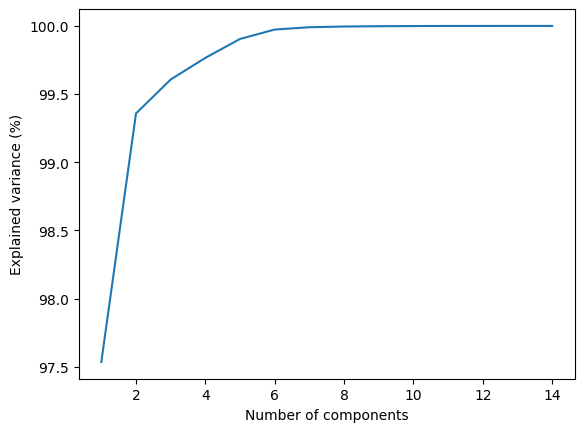

In [83]:
components = len(pca.explained_variance_ratio_) if components is None else components
plt.plot(range(1, components+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

####Aplicando o PCA

In [84]:
pca_components = abs(pca.components_)

In [85]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))

components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

print('\nThe most important features in each component')

for row in range(pca_components.shape[0]): # get the indices of the top 4 values in each row
  temp = np.argpartition(-(pca_components[row]),6)
  # sort the indices in descending order
  indices = temp[np.argsort((-pca_components[row])[temp])][:6]

  # print the top 4 feature names
  print(f'Component {row}: {df.columns[indices].to_list()}')


Cumulative Variances (Percentage):
[97.53544334 99.35805484 99.60696752]
Number of components: 3

The most important features in each component
Component 0: ['GT_C_airOut_pressure', 'HP_T_exit_pressure', 'GT_shaft_torque', 'GT_C_airOut_temp', 'S_prplr_torque', 'P_prplr_torque']
Component 1: ['GG_rpm', 'ship_speed', 'lever_position', 'T_inj_control', 'fuel_flow', 'GT_exhGas_pressure']
Component 2: ['T_inj_control', 'GT_rpm', 'HP_T_exit_temp', 'GT_exhGas_pressure', 'HP_T_exit_pressure', 'GT_C_airOut_pressure']
Component 3: ['HP_T_exit_temp', 'T_inj_control', 'ship_speed', 'lever_position', 'GT_C_airOut_temp', 'fuel_flow']
Component 4: ['GT_rpm', 'GG_rpm', 'T_inj_control', 'lever_position', 'ship_speed', 'S_prplr_torque']
Component 5: ['GG_rpm', 'GT_rpm', 'S_prplr_torque', 'P_prplr_torque', 'ship_speed', 'lever_position']
Component 6: ['GT_C_airOut_temp', 'GT_exhGas_pressure', 'HP_T_exit_temp', 'GT_rpm', 'S_prplr_torque', 'P_prplr_torque']
Component 7: ['GT_C_airOut_temp', 'GT_exhGas_pres

####Modelagem

In [86]:
# Splitando os dados em treino e teste
X_pca2_train, X_pca2_test, y2_pca2_train, y2_pca2_test = train_test_split(X_pca,y2)

In [87]:
# Aplicando os modelos
y2_models_pca = train_models(X_pca2_train, y2_pca2_train, X_pca2_test, y2_pca2_test, models)
y2_models_pca.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Train Time Mean Absolute Error  \
SVR                     0.008136            0.006476   
KNeighborsRegressor     0.018332            0.000879   
DecisionTreeRegressor   0.039709            0.001088   
BaggingRegressor         0.29369            0.000911   
XGBRegressor            0.826773            0.001255   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                          0.00656            0.000056   
KNeighborsRegressor                          0.00089            0.000004   
DecisionTreeRegressor                       0.001101            0.000007   
BaggingRegressor                            0.000923            0.000004   
XGBRegressor                                0.001271            0.000005   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.007466           -0.000046   
KNeighborsRegressor                   0.001902             0.95457   
DecisionTreeRegressor                 0.002638                 1.0   
BaggingRegressor                      0.002054            0.984962   
XGBRegressor                           0.00229            0.977075   

                      Test Accuracy (R²)  
SVR                            -0.000423  
KNeighborsRegressor             0.935081  
DecisionTreeRegressor            0.87512  
BaggingRegressor                0.924252  
XGBRegressor                     0.90588

Consideramos menos vantajoso, pois precisa de bastante features

###PCA do Top VIF

In [88]:
features = y2_calculated_vif[y2_calculated_vif['VIF'] < 300].index.to_list()
print('Features (VIF < 300):\n', features)

x2_pca_300 = X.loc[:, features]



Features (VIF < 300):
 ['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']


In [89]:
# Performing Standardization
sc = StandardScaler()
X_scaled = sc.fit_transform(x2_pca_300)

In [90]:
components = 2
# None return the same number of original features in the dataset
# floating number between 0<n<1 return the number of components needed to capture the specified percentage of variability in the data
# an integer to indicate how many principal componentes you want to reduce the features to.

pca = PCA(n_components = components)

# Perform PCA on the scaled data
pca.fit(X_scaled)

print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)

Variances (Percentage):
[95.31759907  4.1212367 ]


Text(0, 0.5, 'Explained variance (%)')

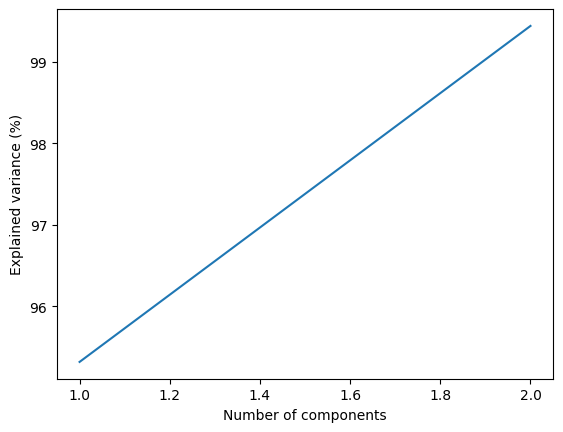

In [91]:
components = len(pca.explained_variance_ratio_) if components is None else components
plt.plot(range(1, components+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

####Aplicando o PCA

In [92]:
pca_components = abs(pca.components_)
print(pca_components)

[[0.57537144 0.56895791 0.58756669]
 [0.62773132 0.76771713 0.12870039]]


In [93]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))

components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

print('\nThe most important features in each component')

for row in range(pca_components.shape[0]): # get the indices of the top 4 values in each row
  temp = np.argpartition(-(pca_components[row]),2)
  # sort the indices in descending order
  indices = temp[np.argsort((-pca_components[row])[temp])][:]

  # print the top 4 feature names
  print(f'Component {row}: {df.columns[indices].to_list()}')

Cumulative Variances (Percentage):
[95.31759907 99.43883577]
Number of components: 2

The most important features in each component
Component 0: ['GT_shaft_torque', 'lever_position', 'ship_speed']
Component 1: ['ship_speed', 'lever_position', 'GT_shaft_torque']


####Modelagem

In [94]:
#sc = StandardScaler()
#X_scaled = sc.fit_transform(x1_pca_500)

#pca = PCA(n_components=2)
#X_pca = pca.fit_transform(X_scaled)

# Splitando os dados em traino e teste
X_pca2_train, X_pca2_test, y2_pca2_train, y2_pca2_test = train_test_split(X_pca,y2)

Redução de Dimensão e PCA

In [95]:
# Aplicando os modelos
y2_PCA2_500_models = train_models(X_pca2_train, y2_pca2_train, X_pca2_test, y2_pca2_test, models)
y2_PCA2_500_models.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Train Time Mean Absolute Error  \
SVR                     0.006189            0.006497   
KNeighborsRegressor     0.017862             0.00111   
DecisionTreeRegressor   0.028573            0.001511   
BaggingRegressor        0.250417            0.001152   
XGBRegressor            0.530912             0.00149   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                          0.00658            0.000056   
KNeighborsRegressor                         0.001124            0.000007   
DecisionTreeRegressor                       0.001531            0.000011   
BaggingRegressor                            0.001167            0.000007   
XGBRegressor                                0.001509            0.000008   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.007495           -0.000006   
KNeighborsRegressor                   0.002623            0.919987   
DecisionTreeRegressor                 0.003387                 1.0   
BaggingRegressor                      0.002667             0.97691   
XGBRegressor                          0.002805            0.954862   

                      Test Accuracy (R²)  
SVR                            -0.000058  
KNeighborsRegressor             0.877558  
DecisionTreeRegressor           0.795746  
BaggingRegressor                0.873421  
XGBRegressor                     0.85992

Redução de Dimensão sem PCA (apenas para comparação)

In [96]:
y2_models_500.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Train Time Mean Absolute Error  \
SVR                     0.003547            0.006468   
KNeighborsRegressor     0.005586            0.000464   
DecisionTreeRegressor   0.063516            0.000841   
BaggingRegressor        0.472604            0.000518   
XGBRegressor            0.711254            0.000842   

                      Mean Absolute Percentual Error Mean Squared  Error  \
SVR                                         0.006551            0.000056   
KNeighborsRegressor                          0.00047            0.000001   
DecisionTreeRegressor                       0.000852            0.000002   
BaggingRegressor                            0.000525            0.000001   
XGBRegressor                                0.000853            0.000001   

                      Root Mean Squared  Error Train Accuracy (R²)  \
SVR                                   0.007462                -0.0   
KNeighborsRegressor                   0.001026            0.984548   
DecisionTreeRegressor                  0.00149                 1.0   
BaggingRegressor                      0.001011            0.995724   
XGBRegressor                          0.001193            0.991129   

                      Test Accuracy (R²)  
SVR                            -0.000002  
KNeighborsRegressor             0.981085  
DecisionTreeRegressor           0.960152  
BaggingRegressor                0.981651  
XGBRegressor                    0.974437

O resultado foi levemente menor.

Seguiremos com os modelos obtidos no y2_models_300 <br>
KNeighborsRegressor e BaggingRegressor

##Modelos Definidos

In [97]:
y2_pred_bagg_300 = y2_models_300['Y Predicted Test']['BaggingRegressor']
y2_pred_knn_300 = y2_models_300['Y Predicted Test']['KNeighborsRegressor']

In [98]:
x_columns_300 = list(x2_test_300)
x_columns_300

['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']

## Visualização das Predições

In [99]:
print('KNeighborsRegressor')
Graph_prediction2d(x2_train[x_columns_300], y2_train, x2_test[x_columns_300], y2_test, y2_pred_knn_300)

KNeighborsRegressor


In [100]:
print('BaggingRegressor')
Graph_prediction2d(x2_train[x_columns_300], y2_train, x2_test[x_columns_300], y2_test, y2_pred_bagg_300)

BaggingRegressor


In [101]:
print('KNeighborsRegressor')
Graph_prediction3d(x2_test[x_columns_300], y2_test, y2_pred_knn_300)

KNeighborsRegressor


In [102]:
print('BaggingRegressor')
Graph_prediction3d(x2_test[x_columns_300], y2_test, y2_pred_bagg_300)

BaggingRegressor


In [103]:
fig = px.scatter_3d(x=x2_test[x_columns_300].iloc[:,0], y=x2_test[x_columns_300].iloc[:,2], z=x2_test[x_columns_300].iloc[:,1],  color=y2_test)
fig.show()



## Aprimoramento dos Hiperparâmetros

###KNN

In [104]:
param_grid_knn = {
    'n_neighbors': range(1,19,2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    #'algorithm': [auto, 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(15,40,5)
}

#### Grid Search

In [105]:
gs2 = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_knn,
    verbose=1,
    cv = 3,
    n_jobs = -1
)

gs_knn_results = gs2.fit(x2_train_300.values, y2_train)

Fitting 3 folds for each of 270 candidates, totalling 810 fits


####Bayesian Optimization

In [106]:
# create a study (aim to maximize score)
y2_study = optuna.create_study(sampler=TPESampler(), direction='maximize')

time_start = time.time()
y2_study.optimize(objective_knn, n_trials=100)
time_bayesian = time.time() - time_start

[I 2023-04-01 23:19:10,557] A new study created in memory with name: no-name-ff2a0cea-573e-41bd-a559-b1fd14fac462
[I 2023-04-01 23:19:10,588] Trial 0 finished with value: 0.9643022197207024 and parameters: {'n_neighbors': 17, 'leaf_size': 20, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.9643022197207024.
[I 2023-04-01 23:19:10,611] Trial 1 finished with value: 0.9727242600975594 and parameters: {'n_neighbors': 1, 'leaf_size': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.9727242600975594.
[I 2023-04-01 23:19:10,637] Trial 2 finished with value: 0.9723966249976563 and parameters: {'n_neighbors': 11, 'leaf_size': 25, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.9727242600975594.
[I 2023-04-01 23:19:10,658] Trial 3 finished with value: 0.9864576314054867 and parameters: {'n_neighbors': 3, 'leaf_size': 30, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 3 with value: 0.986457631405

In [107]:
# Default
y2_default_knn_model = y2_models_300['Model']['KNeighborsRegressor']

#Gs
y2_gs_knn_model = gs_knn_results.best_estimator_

#Bay
y2_bay_knn_model = KNeighborsRegressor(**y2_study.best_trial.params)
y2_bay_knn_model.fit(x2_train_300.values, y2_train)


KNeighborsRegressor(n_neighbors=3, weights='distance')

In [108]:
pd.DataFrame([y2_default_knn_model.get_params(),
              y2_gs_knn_model.get_params(),
              y2_bay_knn_model.get_params()],
              index=[
                  'KNN Default',
                  'KNN Grid Search',
                  'KNN Bayesian Optimization'])

algorithm  leaf_size     metric metric_params  \
KNN Default                    auto         30  minkowski          None   
KNN Grid Search                auto         15  manhattan          None   
KNN Bayesian Optimization      auto         30  minkowski          None   

                          n_jobs  n_neighbors  p   weights  
KNN Default                 None            5  2   uniform  
KNN Grid Search             None            3  2  distance  
KNN Bayesian Optimization   None            3  2  distance

In [109]:
optuna.visualization.plot_param_importances(y2_study)

In [110]:
y2_models_knn = {
    'KNN Default': y2_default_knn_model,
    'KNN Grid Search': y2_gs_knn_model,
    'KNN Bayesian Optimization ': y2_bay_knn_model
}

In [111]:
y2_metrics_models_knn = metrics_models(x2_train_300.values, y2_train, x2_test_300.values, y2_test, y2_models_knn)
y2_metrics_models_knn.drop('Y Predicted Test', axis=1).drop('Model', axis=1)

Mean Absolute Error Mean Absolute Percentual Error  \
KNN Default                           0.000482                       0.000488   
KNN Grid Search                       0.000456                       0.000462   
KNN Bayesian Optimization             0.000444                        0.00045   

                           Mean Squared  Error Root Mean Squared  Error  \
KNN Default                           0.000001                 0.001082   
KNN Grid Search                       0.000001                 0.000961   
KNN Bayesian Optimization             0.000001                 0.000975   

                           Train Accuracy (R²) Test Accuracy (R²)  
KNN Default                           0.980181           0.978976  
KNN Grid Search                            1.0           0.983411  
KNN Bayesian Optimization                  1.0           0.982933

###BaggingRegressor

In [112]:
param_grid_bagg = {
    'n_estimators': range(0,51,5),
    'max_samples' : [0.6, 0.8, 1.0],
    'max_features': [0.6, 0.8, 1.0],
    #'bootstrap': [True, False],
    #'oob_score': [True, False],
    #'bootstrap_features': [True, False],
    'warm_start': [True, False],
    #'base_estimator': [DecisionTreeRegressor()], #default = DecisionTreeRegressor
    #'base_estimator__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    #'base_estimator__splitter': ['best','random'],
    #'base_estimator__max_depth': range(1,13,2),
    #'base_estimator__min_samples_leaf': range(1,10,1),
    #'base_estimator__min_weight_fraction_leaf': [x * 0.1 for x in range(0, 11)],
    #'base_estimator__max_features': ['auto','log2','sqrt',None],
    #'base_estimator__max_leaf_nodes' : [None] + [*range(10,100,10)]
}

####Grid Search

In [113]:
y2_gs = GridSearchCV(
    BaggingRegressor(),
    param_grid_bagg,
    verbose=1,
    cv = 3,
    n_jobs = -1
)

y2_gs_bagg_results = y2_gs.fit(x2_train_300.values, y2_train.values)

Fitting 3 folds for each of 198 candidates, totalling 594 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


54 fits failed out of a total of 594.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_bagging.py", line 326, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils/_

####Bayesian Optimization

In [114]:
#final_model = y2_metrics_models["Model"][0]
final_model = y2_models_300['Model']['KNeighborsRegressor']

In [115]:
def objective_bagg(trial):
  """return the R² Score"""
  x_train = x2_train_300
  y_train = y2_train
  x_test = x2_test_300
  y_test = y2_test
  # search space
  param_obj_bagg = {
      'n_estimators': trial.suggest_categorical('n_estimators', range(1,51,5)),
      'max_samples' : trial.suggest_categorical('max_samples', [0.6, 0.8, 1.0]),
      'max_features': trial.suggest_categorical('max_features', [0.6, 0.8, 1.0]),

      'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
      #'oob_score': trial.suggest_categorical('oob_score', [True, False]),
      'bootstrap_features': trial.suggest_categorical('bootstrap_features', [True, False]),
      'warm_start': trial.suggest_categorical('warm_start', [True, False]),

      #'base_estimator': trial.suggest_categorical('base_estimator', [DecisionTreeRegressor()]),
      #'base_estimator__criterion': trial.suggest_categorical('base_estimator__criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
      #'base_estimator__splitter': trial.suggest_categorical('base_estimator__splitter', ['best','random']),
      #'base_estimator__max_depth': trial.suggest_int('base_estimator__max_depth', low=1, high=13, step=2),
      #'base_estimator__min_samples_leaf': trial.suggest_int('base_estimator__min_samples_leaf', low=1, high=10, step=1),
      #'base_estimator__min_weight_fraction_leaf': trial.suggest_int('base_estimator__min_weight_fraction_leaf', low=0.1, high=1.0, step=0.1),
      #'base_estimator__max_features': trial.suggest_categorical('base_estimator__max_features', ['auto','log2','sqrt',None]),
      #'base_estimator__max_leaf_nodes' : trial.suggest_categorical('base_estimator__max_leaf_nodes', [None,10,20,30,40,50,60,70,80,90]) 

  }

  bagg = BaggingRegressor(**param_obj_bagg)
  
  bagg.fit(x_train, y_train)
  score = bagg.score(x_test, y_test)
  return score

In [116]:
# create a study (aim to maximize score)
y2_study_bagg = optuna.create_study(sampler=TPESampler(), direction='maximize')

time_start = time.time()
y2_study_bagg.optimize(objective_bagg, n_trials=100)
time_bayesian_bagg = time.time() - time_start

[I 2023-04-01 23:22:43,966] A new study created in memory with name: no-name-842b17ec-1371-4397-854b-e09653616888
[I 2023-04-01 23:22:46,246] Trial 0 finished with value: 0.1628745696870284 and parameters: {'n_estimators': 41, 'max_samples': 1.0, 'max_features': 0.6, 'bootstrap': False, 'bootstrap_features': False, 'warm_start': True}. Best is trial 0 with value: 0.1628745696870284.
[I 2023-04-01 23:22:46,689] Trial 1 finished with value: 0.28159237420295025 and parameters: {'n_estimators': 16, 'max_samples': 0.8, 'max_features': 0.6, 'bootstrap': True, 'bootstrap_features': False, 'warm_start': False}. Best is trial 1 with value: 0.28159237420295025.
[I 2023-04-01 23:22:47,563] Trial 2 finished with value: 0.920063527945705 and parameters: {'n_estimators': 21, 'max_samples': 0.8, 'max_features': 1.0, 'bootstrap': True, 'bootstrap_features': True, 'warm_start': True}. Best is trial 2 with value: 0.920063527945705.
[I 2023-04-01 23:22:49,178] Trial 3 finished with value: 0.8480648847484

In [117]:
y2_default_bagg_model = y2_models_300['Model']['BaggingRegressor']

y2_gs_bagg_model = y2_gs_bagg_results.best_estimator_

y2_bay_bagg_model = BaggingRegressor(**y2_study_bagg.best_trial.params)
y2_bay_bagg_model.fit(x2_train_300, y2_train)

BaggingRegressor(bootstrap=False, max_samples=0.8, n_estimators=26,
                 warm_start=True)

In [118]:
y2_models_bagg = {
    'Bagg Default': y2_default_bagg_model,
    'Bagg Grid Search': y2_gs_bagg_model,
    'Bagg Bayesian Optimization ': y2_bay_bagg_model
}

y2_metrics_models_bagg = metrics_models(x2_train_300, y2_train, x2_test_300, y2_test, y2_models_bagg)
y2_metrics_models_bagg.drop('Y Predicted Test', axis=1).drop('Model', axis=1)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but BaggingRegressor was fitted without feature names

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but BaggingRegressor was fitted without feature names

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but BaggingRegressor was fitted without feature names

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but BaggingRegressor was fitted without feature names

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but BaggingRegressor was fitted without feature names

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but BaggingRegressor was fitted without feature names



Mean Absolute Error  \
Bagg Default                           0.000525   
Bagg Grid Search                        0.00045   
Bagg Bayesian Optimization             0.000475   

                            Mean Absolute Percentual Error  \
Bagg Default                                      0.000532   
Bagg Grid Search                                  0.000457   
Bagg Bayesian Optimization                        0.000481   

                            Mean Squared  Error Root Mean Squared  Error  \
Bagg Default                           0.000001                 0.001044   
Bagg Grid Search                       0.000001                 0.001002   
Bagg Bayesian Optimization             0.000001                 0.000986   

                            Train Accuracy (R²) Test Accuracy (R²)  
Bagg Default                           0.994278           0.980414  
Bagg Grid Search                       0.995972           0.981953  
Bagg Bayesian Optimization             0.998664           0.982546

In [119]:
optuna.visualization.plot_param_importances(y2_study_bagg)

## Conclusão

Modelos ordenados do melhor para o pior Test Accuracy (R²)

In [120]:
y2_metrics_models = y2_metrics_models_knn.append(y2_metrics_models_bagg).sort_values('Test Accuracy (R²)', ascending=False)
y2_metrics_models.drop('Y Predicted Test', axis=1).drop('Model', axis=1)

<ipython-input-120-5aa34ec1a92c>:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Mean Absolute Error  \
KNN Grid Search                        0.000456   
KNN Bayesian Optimization              0.000444   
Bagg Bayesian Optimization             0.000475   
Bagg Grid Search                        0.00045   
Bagg Default                           0.000525   
KNN Default                            0.000482   

                            Mean Absolute Percentual Error  \
KNN Grid Search                                   0.000462   
KNN Bayesian Optimization                          0.00045   
Bagg Bayesian Optimization                        0.000481   
Bagg Grid Search                                  0.000457   
Bagg Default                                      0.000532   
KNN Default                                       0.000488   

                            Mean Squared  Error Root Mean Squared  Error  \
KNN Grid Search                        0.000001                 0.000961   
KNN Bayesian Optimization              0.000001                 0.000975   
Bagg Bayesian Optimization             0.000001                 0.000986   
Bagg Grid Search                       0.000001                 0.001002   
Bagg Default                           0.000001                 0.001044   
KNN Default                            0.000001                 0.001082   

                            Train Accuracy (R²) Test Accuracy (R²)  
KNN Grid Search                             1.0           0.983411  
KNN Bayesian Optimization                   1.0           0.982933  
Bagg Bayesian Optimization             0.998664           0.982546  
Bagg Grid Search                       0.995972           0.981953  
Bagg Default                           0.994278           0.980414  
KNN Default                            0.980181           0.978976

In [121]:
y2_final_model = y2_default_knn_model

#MLOps

##Salvar o Modelo

In [122]:
with open('model_y1.pkl', 'wb') as files:
    pickle.dump(y1_final_model, files)

with open('model_y2.pkl', 'wb') as files:
    pickle.dump(y2_final_model, files)

##Carregar o Modelo

```
requirements.txt

# Function dependencies
# package>=version
scikit-learn==1.2.1
```



In [123]:
import pickle

In [126]:
# ['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']
test = [[12.008,   7094.118,   578.701]]  # y1  >>>   0.978

# load saved model
with open('model_y1.pkl' , 'rb') as f:
    y1_model = pickle.load(f)

# check prediction
y1_model.predict(test)

array([0.97813043])

In [127]:
# ['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']
test = [[26.373, 8494.777, 731.494]]  # y2  >>>   0.975

# load saved model
with open('model_y2.pkl' , 'rb') as f:
    y2_model = pickle.load(f)

# check prediction
y2_model.predict(test)



array([0.976])